# Exploratory Data Analysis: Advanced Acoustic Perspectives

**Course**: DATASCI207 - Applied Machine Learning  
**Author**: Bjorn Melin (bjorn_melin@berkeley.edu)  
**Date**: October 2025  
**Dataset**: RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)

---

## Notebook Objectives

This analysis provides **complementary perspectives** to the team's feature extraction work:

| Analysis | Question Addressed | Visualization |
|----------|-------------------|---------------|
| **Speaker/Actor Analysis** | Which actors are acoustically similar? | PCA, similarity heatmap, dendrogram |
| **Emotion Space Visualization** | How do emotions cluster in feature space? | t-SNE, UMAP |
| **Cross-Emotion Distances** | Which emotion pairs overlap? | Distance heatmap, confusion prediction |
| **Intensity Effects** | How does intensity affect acoustic features? | Cohen's d, volcano plot |
| **Temporal Evolution** | How do features evolve within utterances? | Pitch/energy contours |
| **Frequency Attribution** | Which bands carry emotion information? | Spectral fingerprints |

**Key Differentiators from Team Notebooks**:
- Pratheek: Compact features (33) for SVM/XGBoost
- Nithya: Comprehensive features (180) for CNN
- **Bjorn (this notebook)**: Meta-analysis of feature space structure, speaker effects, and temporal dynamics

## 1. Setup

In [1]:
# =============================================================================
# REPRODUCIBILITY CONFIGURATION
# Based on notebook-ml-architect reproducibility_header.py
# =============================================================================

import os
import random
import sys
from datetime import datetime

import numpy as np

# Configuration
SEED = 42

def set_seeds(seed: int = SEED) -> None:
    """Set random seeds for reproducibility across all common ML libraries."""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    # TensorFlow (if available)
    try:
        import tensorflow as tf
        tf.random.set_seed(seed)
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
    except ImportError:
        pass
    
    print(f"Random seeds set to: {seed}")

def print_environment() -> dict:
    """Print and return environment information for reproducibility."""
    env_info = {
        "timestamp": datetime.now().isoformat(),
        "python_version": sys.version,
        "platform": sys.platform,
        "seed": SEED,
        "packages": {},
    }
    
    print("=" * 60)
    print("Environment Information")
    print("=" * 60)
    print(f"Timestamp: {env_info['timestamp']}")
    print(f"Python: {sys.version.split()[0]}")
    print(f"Platform: {env_info['platform']}")
    print(f"Seed: {env_info['seed']}")
    print()
    
    packages = ["numpy", "pandas", "sklearn", "scipy", "matplotlib", 
                "seaborn", "librosa", "umap"]
    
    print("Package Versions:")
    for pkg_name in packages:
        try:
            pkg = __import__(pkg_name)
            version = getattr(pkg, "__version__", "unknown")
            env_info["packages"][pkg_name] = version
            print(f"  {pkg_name}: {version}")
        except ImportError:
            print(f"  {pkg_name}: not installed")
    
    print("=" * 60)
    return env_info

# Set seeds immediately (before any other imports that use randomness)
set_seeds(SEED)

# Print environment info
ENV_INFO = print_environment()

2025-12-10 21:42:39.190430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 21:42:39.227618: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 21:42:40.150775: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Random seeds set to: 42
Environment Information
Timestamp: 2025-12-10T21:42:41.054351
Python: 3.11.13
Platform: linux
Seed: 42

Package Versions:
  numpy: 2.3.5
  pandas: 2.3.3
  sklearn: 1.8.0
  scipy: 1.16.2
  matplotlib: 3.10.8
  seaborn: 0.13.2
  librosa: 0.11.0
  umap: 0.5.9.post2


In [2]:
# =============================================================================
# IMPORTS (All at top per ml-workflow-guide.md)
# =============================================================================

# Standard library
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd

# Audio processing
import librosa
import librosa.display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Statistical analysis
from scipy import stats
from scipy.spatial.distance import pdist, squareform, cosine
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.interpolate import interp1d

# Progress bars
from tqdm.auto import tqdm

# Optional: UMAP (better than t-SNE for preserving global structure)
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available. Install with: pip install umap-learn")

# =============================================================================
# DISPLAY CONFIGURATION
# =============================================================================

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 100

# Custom color palettes
EMOTION_COLORS = {
    'angry': '#E53935',      # Red
    'calm': '#43A047',       # Green
    'disgust': '#8E24AA',    # Purple
    'fearful': '#FB8C00',    # Orange
    'happy': '#FDD835',      # Yellow
    'neutral': '#757575',    # Gray
    'sad': '#1E88E5',        # Blue
    'surprised': '#00ACC1'   # Cyan
}

GENDER_COLORS = {'male': '#4ECDC4', 'female': '#FF6B6B'}
EMOTION_ORDER = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

print("All imports successful.")
print(f"UMAP available: {UMAP_AVAILABLE}")

All imports successful.
UMAP available: True


## 2. Data Loading

**Data Source**: RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)  
**Citation**: Livingstone, S.R., & Russo, F.A. (2018). PLOS ONE, 13(5), e0196391.  
**Access**: https://zenodo.org/record/1188976

### Filename Format
`Modality-VocalChannel-Emotion-Intensity-Statement-Repetition-Actor.wav`

| Position | Meaning | Values |
|----------|---------|--------|
| 1 | Modality | 01=full-AV, 02=video-only, 03=audio-only |
| 2 | Vocal Channel | 01=speech, 02=song |
| 3 | Emotion | 01-08 (see mapping below) |
| 4 | Intensity | 01=normal, 02=strong |
| 5 | Statement | 01="Kids...", 02="Dogs..." |
| 6 | Repetition | 01=1st, 02=2nd |
| 7 | Actor | 01-24 (odd=male, even=female) |

In [3]:
# =============================================================================
# CONFIGURATION (No hardcoded paths per anti-patterns.md)
# =============================================================================

# Data path - relative to project root
PROJECT_ROOT = Path('..').resolve().parent
DATA_PATH = PROJECT_ROOT / 'data' / 'raw' / 'ravdess'

# Output path for analysis artifacts
OUTPUT_PATH = PROJECT_ROOT / 'data' / 'processed' / 'bjorn_analysis'
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Audio processing parameters
SAMPLE_RATE = 22050  # Standard for speech processing
N_MFCC = 40          # More than Pratheek (13) for better clustering
HOP_LENGTH = 512     # ~23ms at 22050 Hz

# Metadata mappings
EMOTION_LABELS = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

INTENSITY_LABELS = {'01': 'normal', '02': 'strong'}

STATEMENT_LABELS = {
    '01': 'Kids are talking by the door',
    '02': 'Dogs are sitting by the door'
}

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Data path exists: {DATA_PATH.exists()}")

Project root: /home/bjorn/repos/berkeley/DS207/EDFS
Data path: /home/bjorn/repos/berkeley/DS207/EDFS/data/raw/ravdess
Output path: /home/bjorn/repos/berkeley/DS207/EDFS/data/processed/bjorn_analysis
Data path exists: True


In [4]:
# =============================================================================
# METADATA LOADING
# =============================================================================

def parse_filename(filepath: Path) -> dict:
    """Parse RAVDESS filename to extract metadata.
    
    Args:
        filepath: Path to audio file
        
    Returns:
        Dictionary with extracted metadata
    """
    parts = filepath.stem.split('-')
    actor_id = int(parts[6])
    
    return {
        'filepath': str(filepath),
        'filename': filepath.name,
        'modality': parts[0],
        'vocal_channel': parts[1],
        'emotion_code': parts[2],
        'emotion': EMOTION_LABELS[parts[2]],
        'intensity_code': parts[3],
        'intensity': INTENSITY_LABELS.get(parts[3], 'normal'),
        'statement_code': parts[4],
        'statement': STATEMENT_LABELS.get(parts[4], 'Unknown'),
        'repetition': parts[5],
        'actor_id': actor_id,
        'actor': f'Actor_{actor_id:02d}',
        'gender': 'male' if actor_id % 2 == 1 else 'female'
    }

def load_metadata(data_path: Path) -> pd.DataFrame:
    """Load all audio files and extract metadata.
    
    Args:
        data_path: Path to RAVDESS data directory
        
    Returns:
        DataFrame with all file metadata
    """
    audio_files = sorted(data_path.glob('**/*.wav'))
    
    if len(audio_files) == 0:
        raise FileNotFoundError(f"No .wav files found in {data_path}")
    
    metadata = [parse_filename(f) for f in audio_files]
    df = pd.DataFrame(metadata)
    
    return df

# Load metadata
df_meta = load_metadata(DATA_PATH)

print(f"Loaded {len(df_meta):,} audio files")
print(f"Memory usage: {df_meta.memory_usage(deep=True).sum() / 1e6:.2f} MB")
print(f"\nColumns: {list(df_meta.columns)}")
df_meta.head()

Loaded 1,440 audio files
Memory usage: 1.33 MB

Columns: ['filepath', 'filename', 'modality', 'vocal_channel', 'emotion_code', 'emotion', 'intensity_code', 'intensity', 'statement_code', 'statement', 'repetition', 'actor_id', 'actor', 'gender']


filepath  \
0  /home/bjorn/repos/berkeley/DS207/EDFS/data/raw...   
1  /home/bjorn/repos/berkeley/DS207/EDFS/data/raw...   
2  /home/bjorn/repos/berkeley/DS207/EDFS/data/raw...   
3  /home/bjorn/repos/berkeley/DS207/EDFS/data/raw...   
4  /home/bjorn/repos/berkeley/DS207/EDFS/data/raw...   

                   filename modality vocal_channel emotion_code  emotion  \
0  03-01-01-01-01-01-01.wav       03            01           01  neutral   
1  03-01-01-01-01-02-01.wav       03            01           01  neutral   
2  03-01-01-01-02-01-01.wav       03            01           01  neutral   
3  03-01-01-01-02-02-01.wav       03            01           01  neutral   
4  03-01-02-01-01-01-01.wav       03            01           02     calm   

  intensity_code intensity statement_code                     statement  \
0             01    normal             01  Kids are talking by the door   
1             01    normal             01  Kids are talking by the door   
2             01    normal             02  Dogs are sitting by the door   
3             01    normal             02  Dogs are sitting by the door   
4             01    normal             01  Kids are talking by the door   

  repetition  actor_id     actor gender  
0         01         1  Actor_01   male  
1         02         1  Actor_01   male  
2         01         1  Actor_01   male  
3         02         1  Actor_01   male  
4         01         1  Actor_01   male

In [5]:
# =============================================================================
# DATA VALIDATION (Sanity checks per anti-patterns.md)
# =============================================================================

# Basic assertions
assert df_meta.shape[0] > 0, "Empty dataframe"
assert not df_meta.isnull().all().any(), "All-null columns exist"
assert df_meta['emotion'].nunique() == 8, "Expected 8 emotions"
assert df_meta['actor'].nunique() == 24, "Expected 24 actors"

print("=== DATASET VALIDATION ===")
print(f"Total files: {len(df_meta):,}")
print(f"Actors: {df_meta['actor'].nunique()} (expected: 24)")
print(f"Emotions: {df_meta['emotion'].nunique()} (expected: 8)")
print(f"Gender distribution: {df_meta['gender'].value_counts().to_dict()}")
print(f"\nEmotion counts:")
print(df_meta['emotion'].value_counts().sort_index())

=== DATASET VALIDATION ===
Total files: 1,440
Actors: 24 (expected: 24)
Emotions: 8 (expected: 8)
Gender distribution: {'male': 720, 'female': 720}

Emotion counts:
emotion
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
Name: count, dtype: int64


In [6]:
# =============================================================================
# FEATURE EXTRACTION FOR CLUSTERING (86 features)
# 40 MFCCs (mean) + 40 MFCCs (std) + 6 prosodic = 86 features
# =============================================================================

def extract_clustering_features(filepath: str, sr: int = SAMPLE_RATE) -> np.ndarray:
    """Extract 86 features optimized for speaker/emotion clustering.
    
    Args:
        filepath: Path to audio file
        sr: Sample rate for loading
        
    Returns:
        1D array of 86 features, or None if extraction fails
    """
    try:
        # Load audio
        y, sr = librosa.load(filepath, sr=sr)
        
        # Skip if too short
        if len(y) < sr * 0.5:  # Less than 0.5 seconds
            return None
        
        # MFCCs (40 coefficients) - mean and std across time
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        mfccs_mean = np.mean(mfccs, axis=1)  # 40 features
        mfccs_std = np.std(mfccs, axis=1)    # 40 features
        
        # Prosodic features (6 total)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        rms = np.mean(librosa.feature.rms(y=y))
        
        # Pitch (F0) using YIN algorithm
        f0 = librosa.yin(y, fmin=50, fmax=400, sr=sr)
        pitch_mean = np.median(f0[f0 > 0]) if np.any(f0 > 0) else 0
        
        # Combine all features
        features = np.concatenate([
            mfccs_mean,           # 40 features
            mfccs_std,            # 40 features
            [spectral_centroid, spectral_bandwidth, spectral_rolloff,
             zcr, rms, pitch_mean]  # 6 features
        ])
        
        return features
        
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# Feature names for reference
FEATURE_NAMES = (
    [f'mfcc_{i}_mean' for i in range(1, N_MFCC + 1)] +
    [f'mfcc_{i}_std' for i in range(1, N_MFCC + 1)] +
    ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff',
     'zcr', 'rms_energy', 'pitch_mean']
)

print(f"Feature extraction function defined.")
print(f"Total features per sample: {len(FEATURE_NAMES)}")

Feature extraction function defined.
Total features per sample: 86


In [7]:
# =============================================================================
# EXTRACT FEATURES FROM ALL FILES
# =============================================================================

print("Extracting features from all audio files...")
print("This will take several minutes.\n")

features_list = []
failed_files = []

for idx, row in tqdm(df_meta.iterrows(), total=len(df_meta), desc="Extracting features"):
    features = extract_clustering_features(row['filepath'])
    
    if features is not None:
        features_list.append({
            'index': idx,
            **{name: val for name, val in zip(FEATURE_NAMES, features)}
        })
    else:
        failed_files.append(row['filepath'])

# Create features dataframe
df_features = pd.DataFrame(features_list).set_index('index')

# Merge with metadata
df = df_meta.join(df_features, how='inner')

print(f"\nFeature extraction complete!")
print(f"Successful: {len(df):,} files")
print(f"Failed: {len(failed_files)} files")
print(f"Feature columns: {len(FEATURE_NAMES)}")

Extracting features from all audio files...
This will take several minutes.



Extracting features:   0%|          | 0/1440 [00:00<?, ?it/s]


Feature extraction complete!
Successful: 1,440 files
Failed: 0 files
Feature columns: 86


## 3. Speaker/Actor Analysis

**Research Question**: Are some actors acoustically similar regardless of emotion? Do actors cluster by gender, or are there individual "voice signatures"?

**Why This Matters**: If actors have distinct acoustic signatures, models may overfit to speaker identity rather than emotion. Understanding speaker clustering informs:
1. The importance of speaker-independent train/test splits
2. Whether speaker normalization preprocessing is needed
3. Potential confounds in emotion classification

In [8]:
# =============================================================================
# COMPUTE ACTOR-LEVEL FEATURE MEANS
# =============================================================================

# Validate that feature columns exist in df (defensive check per anti-patterns.md)
feature_cols = list(FEATURE_NAMES)  # Explicit list conversion for pandas compatibility
missing_cols = [col for col in feature_cols if col not in df.columns]

if missing_cols:
    raise ValueError(f"Missing feature columns in df: {missing_cols[:5]}... (showing first 5)")

print(f"Computing actor-level features...")
print(f"  - DataFrame shape: {df.shape}")
print(f"  - Feature columns: {len(feature_cols)}")
print(f"  - Unique actors: {df['actor'].nunique()}")

# Average features across all utterances per actor
# Using explicit list() to ensure pandas compatibility with pandas 2.3.3
actor_features = df.groupby('actor')[feature_cols].mean()

# Add gender info
actor_gender = df.groupby('actor')['gender'].first()

print(f"\nActor feature matrix shape: {actor_features.shape}")
print(f"Actors: {actor_features.index.tolist()[:5]}... (showing first 5)")
actor_features.head()

Computing actor-level features...
  - DataFrame shape: (1440, 100)
  - Feature columns: 86
  - Unique actors: 24

Actor feature matrix shape: (24, 86)
Actors: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']... (showing first 5)


mfcc_1_mean  mfcc_2_mean  mfcc_3_mean  mfcc_4_mean  mfcc_5_mean  \
actor                                                                       
Actor_01  -597.813543    52.774517    -4.016096     9.491054     2.189984   
Actor_02  -584.435526    40.912334   -16.143711     4.416860    -8.810787   
Actor_03  -510.945552    57.346597    -7.628844     7.149660     0.592779   
Actor_04  -559.218505    31.889407   -13.729548     0.677037    -8.830402   
Actor_05  -636.770975    57.829057     3.439691    12.824106     4.126077   

          mfcc_6_mean  mfcc_7_mean  mfcc_8_mean  mfcc_9_mean  mfcc_10_mean  \
actor                                                                        
Actor_01    -0.948429    -6.511696    -8.519296   -12.136202     -4.698768   
Actor_02    -6.672687    -7.065260   -12.383409    -5.609247     -3.372364   
Actor_03    -2.204014   -12.710609    -9.859053    -6.211656     -9.130472   
Actor_04    -8.870865    -7.817561   -15.553742    -8.323843     -4.343186   
Actor_05    -2.485390    -2.904676    -3.909386    -4.174646     -0.914732   

          mfcc_11_mean  mfcc_12_mean  mfcc_13_mean  mfcc_14_mean  \
actor                                                              
Actor_01     -1.155080     -4.675076     -1.260403     -4.706536   
Actor_02     -6.934579     -3.538097     -7.142329      0.490692   
Actor_03      0.083449     -5.642716     -5.416125     -2.033002   
Actor_04     -5.706638     -6.704363     -3.963163      2.047123   
Actor_05      2.122746     -0.200088     -2.440048      0.446518   

          mfcc_15_mean  mfcc_16_mean  mfcc_17_mean  mfcc_18_mean  \
actor                                                              
Actor_01     -2.781020      0.571069     -6.585543     -3.083399   
Actor_02     -5.305222     -3.003898     -1.840326     -1.373067   
Actor_03     -5.359956     -1.490419     -3.858714     -2.948048   
Actor_04     -5.344794     -0.484899     -1.869954     -1.352396   
Actor_05     -0.733562      0.942904     -3.049303     -0.008312   

          mfcc_19_mean  mfcc_20_mean  mfcc_21_mean  mfcc_22_mean  \
actor                                                              
Actor_01     -1.799077     -2.142910     -5.841745     -1.380266   
Actor_02     -2.780478      0.163589     -0.764032     -2.248574   
Actor_03     -2.037897     -3.132628     -5.161130     -1.952939   
Actor_04     -0.958639      1.835535     -1.078412      2.193402   
Actor_05     -0.286349      1.069136     -2.450338      0.905826   

          mfcc_23_mean  mfcc_24_mean  mfcc_25_mean  ...  mfcc_22_std  \
actor                                               ...                
Actor_01     -2.758734     -3.256299     -1.897842  ...     6.064070   
Actor_02     -1.467252      0.070271     -0.577204  ...     9.178514   
Actor_03     -2.396215     -1.753087     -2.510660  ...     7.462265   
Actor_04     -0.529198      2.254163      0.664271  ...    10.299675   
Actor_05     -2.363427      0.959667     -0.727673  ...     5.992961   

          mfcc_23_std  mfcc_24_std  mfcc_25_std  mfcc_26_std  mfcc_27_std  \
actor                                                                       
Actor_01     6.689474     7.714765     6.809394     6.367204     7.878204   
Actor_02     8.781453     8.306034     8.778569     9.403997     9.128807   
Actor_03     7.773169     7.350731     7.591480     7.256067     7.605732   
Actor_04    10.661570    10.130834     9.317085     9.379213     8.848639   
Actor_05     8.184232     6.727932     7.486392     6.186637     7.285560   

          mfcc_28_std  mfcc_29_std  mfcc_30_std  mfcc_31_std  mfcc_32_std  \
actor                                                                       
Actor_01     5.552341     6.383344     5.531666     6.088477     5.741444   
Actor_02     9.287701     9.170953     9.636633     9.048586     9.213486   
Actor_03     7.012501     6.643026     6.295197     6.620779     6.458682   
Actor_04     8.568678     8.611473     8.510662     7.860524  

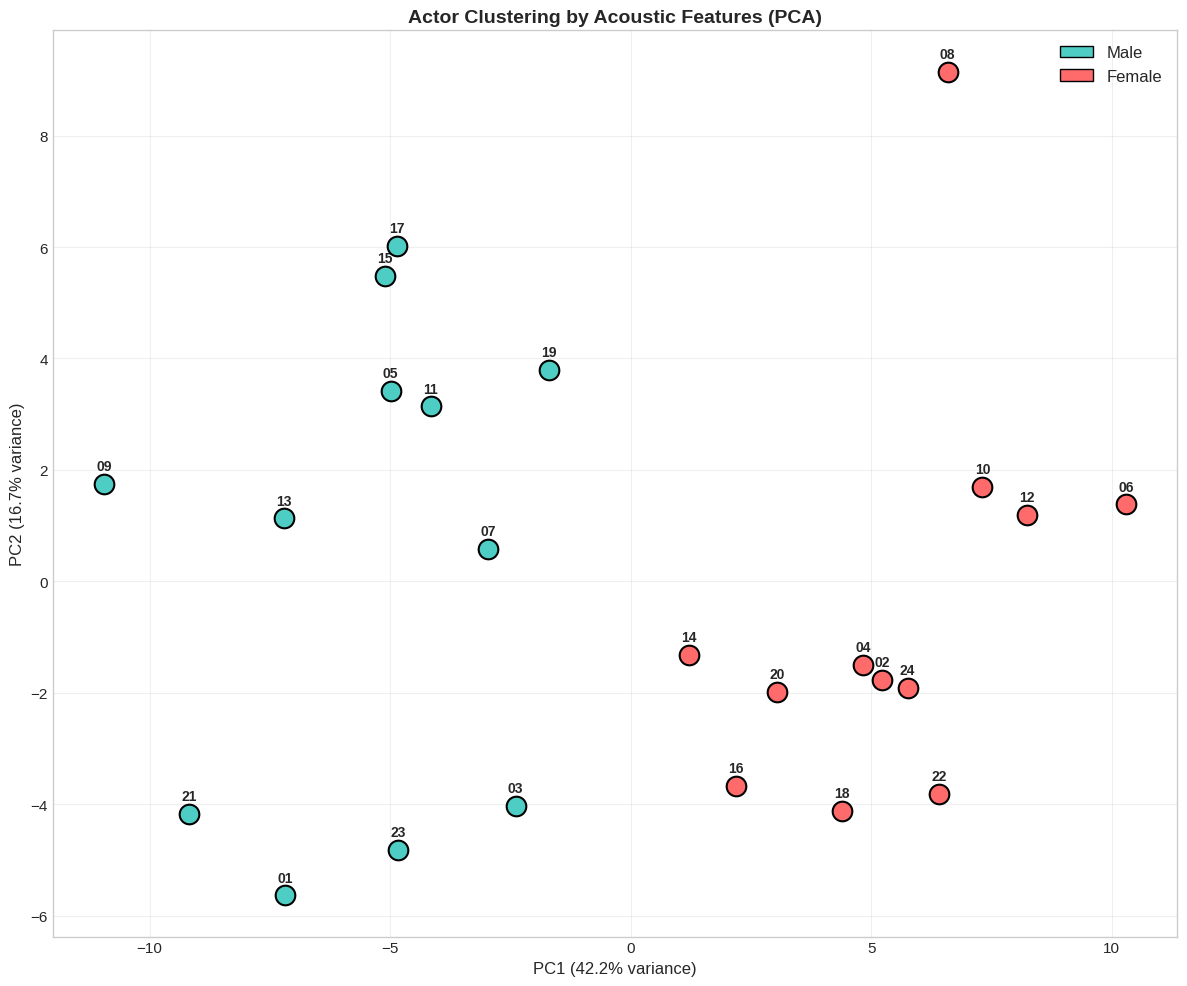


Total variance explained: 58.9%


In [9]:
# =============================================================================
# PCA VISUALIZATION - ACTORS COLORED BY GENDER
# =============================================================================

# Standardize features
scaler = StandardScaler()
actor_features_scaled = scaler.fit_transform(actor_features)

# PCA to 2D
pca_actor = PCA(n_components=2, random_state=SEED)
actor_pca = pca_actor.fit_transform(actor_features_scaled)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 10))

for actor, (x, y) in zip(actor_features.index, actor_pca):
    gender = actor_gender[actor]
    color = GENDER_COLORS[gender]
    
    ax.scatter(x, y, c=color, s=200, edgecolors='black', linewidths=1.5, zorder=5)
    ax.annotate(actor.replace('Actor_', ''), (x, y), 
                textcoords="offset points", xytext=(0, 10),
                ha='center', fontsize=10, fontweight='bold')

# Legend
legend_elements = [
    Patch(facecolor=GENDER_COLORS['male'], edgecolor='black', label='Male'),
    Patch(facecolor=GENDER_COLORS['female'], edgecolor='black', label='Female')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

ax.set_xlabel(f'PC1 ({pca_actor.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_actor.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('Actor Clustering by Acoustic Features (PCA)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'actor_pca_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTotal variance explained: {sum(pca_actor.explained_variance_ratio_)*100:.1f}%")

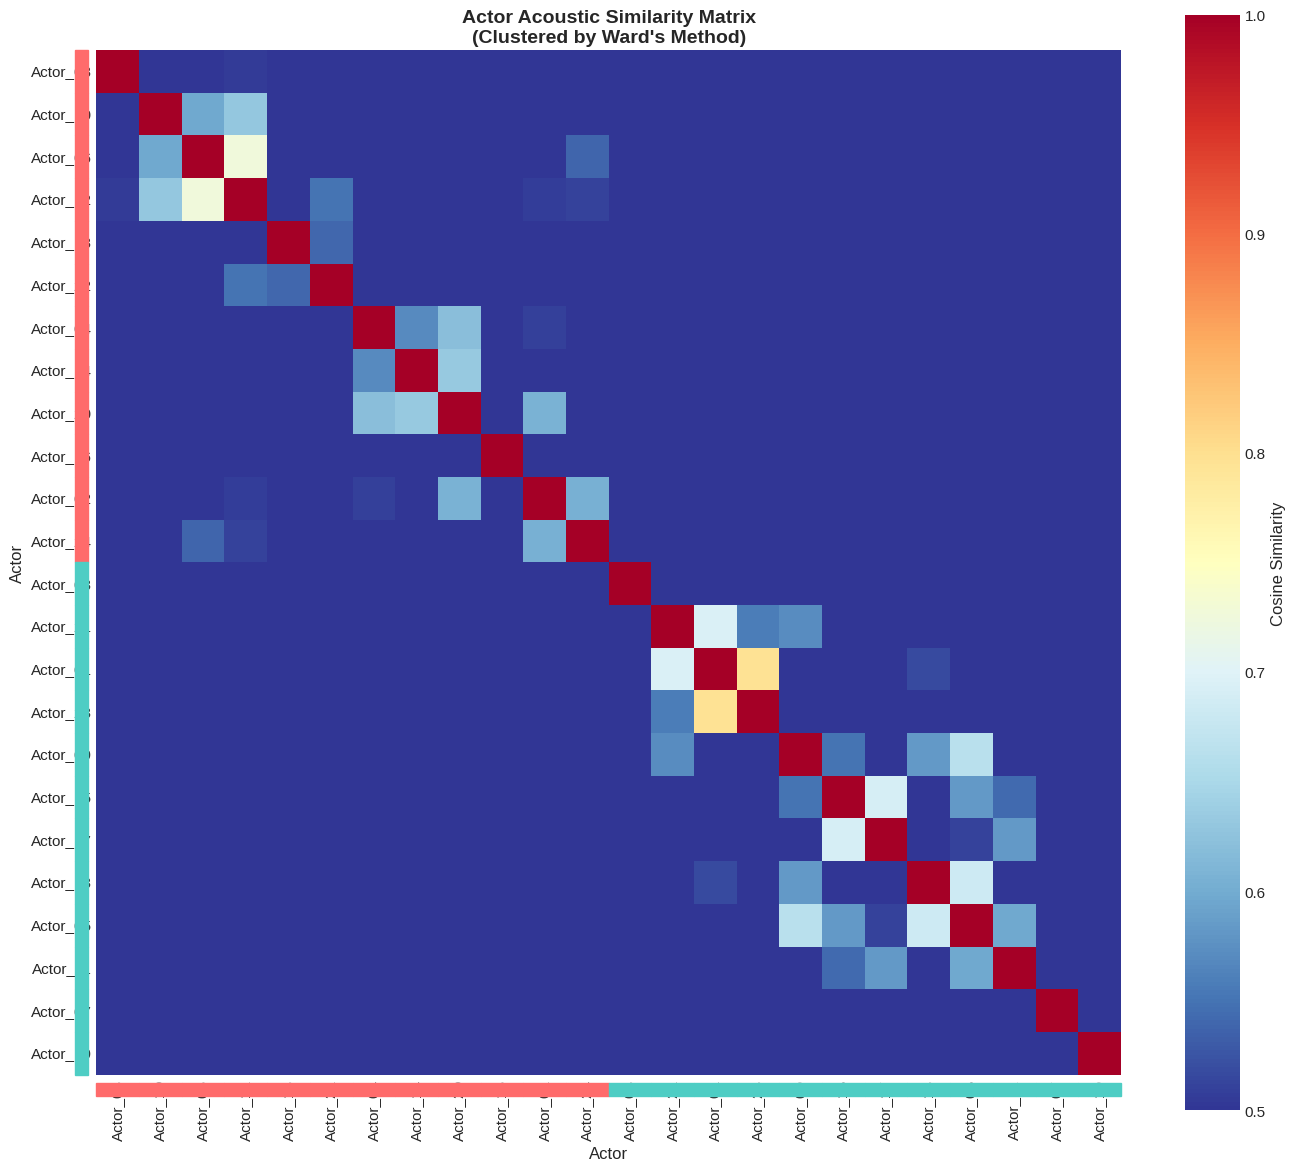

Similarity matrix saved to /home/bjorn/repos/berkeley/DS207/EDFS/data/processed/bjorn_analysis/actor_similarity_matrix.csv


In [10]:
# =============================================================================
# ACTOR SIMILARITY HEATMAP (24x24 Cosine Similarity)
# =============================================================================

# Compute pairwise cosine similarity
n_actors = len(actor_features)
similarity_matrix = np.zeros((n_actors, n_actors))

for i in range(n_actors):
    for j in range(n_actors):
        sim = 1 - cosine(actor_features_scaled[i], actor_features_scaled[j])
        similarity_matrix[i, j] = sim

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=actor_features.index,
    columns=actor_features.index
)

# Hierarchical clustering for ordering
linkage_matrix = linkage(actor_features_scaled, method='ward')
dendro = dendrogram(linkage_matrix, no_plot=True)
order = dendro['leaves']

# Reorder similarity matrix
ordered_actors = [actor_features.index[i] for i in order]
similarity_ordered = similarity_df.loc[ordered_actors, ordered_actors]

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Create row colors for gender
row_colors = [GENDER_COLORS[actor_gender[a]] for a in ordered_actors]

sns.heatmap(similarity_ordered, annot=False, cmap='RdYlBu_r', 
            vmin=0.5, vmax=1.0, square=True,
            cbar_kws={'label': 'Cosine Similarity'}, ax=ax)

# Add gender color bar on side
for i, color in enumerate(row_colors):
    ax.add_patch(plt.Rectangle((-0.5, i), 0.3, 1, color=color, clip_on=False))
    ax.add_patch(plt.Rectangle((i, len(order) + 0.2), 1, 0.3, color=color, clip_on=False))

ax.set_title('Actor Acoustic Similarity Matrix\n(Clustered by Ward\'s Method)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Actor', fontsize=12)
ax.set_ylabel('Actor', fontsize=12)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'actor_similarity_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Save similarity matrix
similarity_df.to_csv(OUTPUT_PATH / 'actor_similarity_matrix.csv')
print(f"Similarity matrix saved to {OUTPUT_PATH / 'actor_similarity_matrix.csv'}")

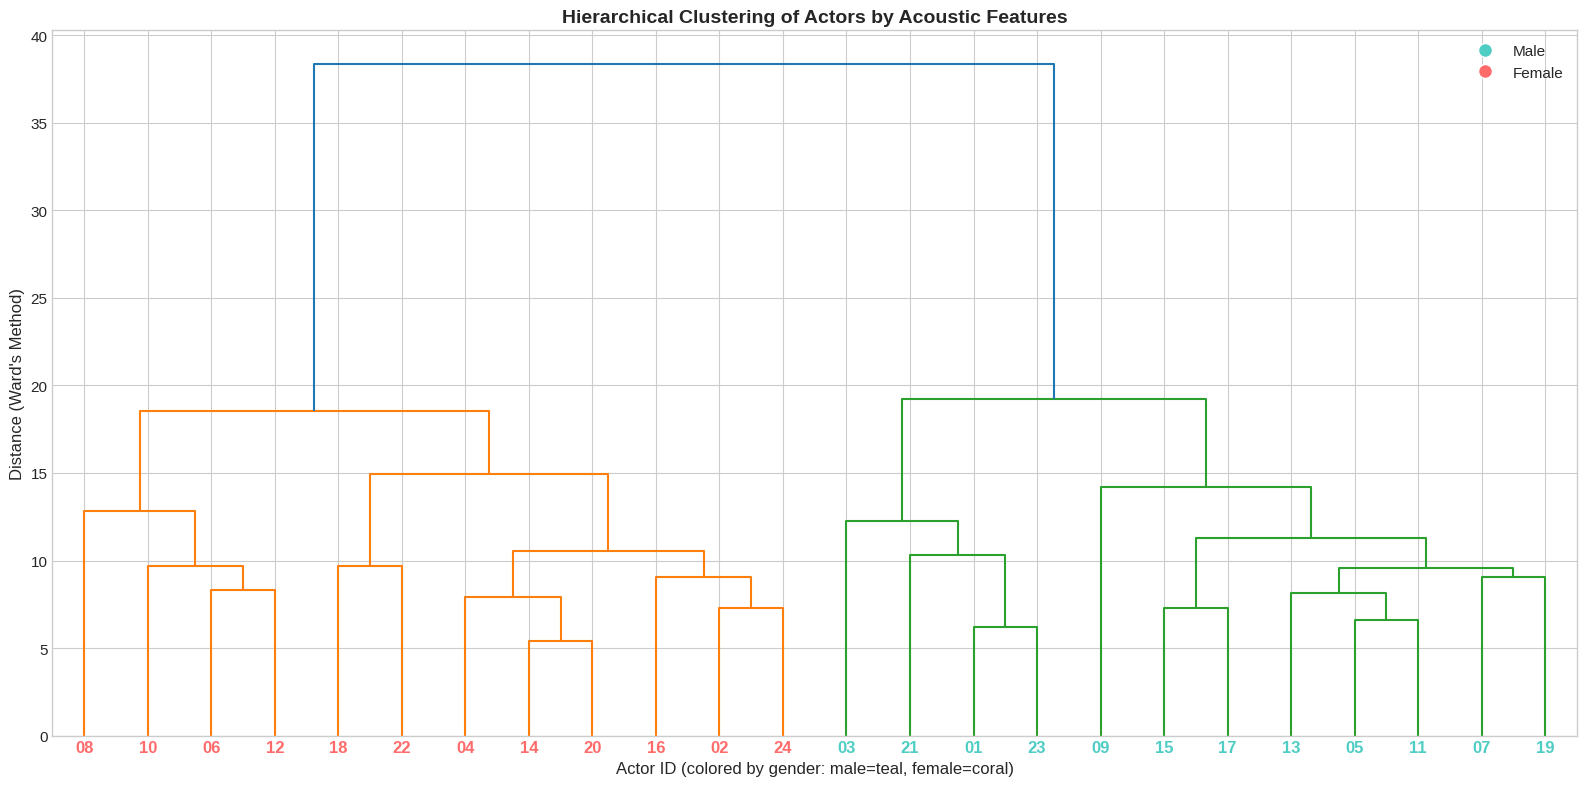

In [11]:
# =============================================================================
# ACTOR DENDROGRAM WITH GENDER COLORING
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 8))

# Create dendrogram
dendro = dendrogram(
    linkage_matrix,
    labels=[a.replace('Actor_', '') for a in actor_features.index],
    leaf_rotation=0,
    leaf_font_size=12,
    ax=ax
)

# Color x-axis labels by gender
ax_labels = ax.get_xticklabels()
for label in ax_labels:
    actor_num = int(label.get_text())
    gender = 'male' if actor_num % 2 == 1 else 'female'
    label.set_color(GENDER_COLORS[gender])
    label.set_fontweight('bold')

ax.set_title('Hierarchical Clustering of Actors by Acoustic Features', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Actor ID (colored by gender: male=teal, female=coral)', fontsize=12)
ax.set_ylabel('Distance (Ward\'s Method)', fontsize=12)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=GENDER_COLORS['male'], 
           markersize=10, label='Male'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=GENDER_COLORS['female'], 
           markersize=10, label='Female')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'actor_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.1 Speaker Analysis Findings

**Key Observations**:
1. **Gender is the dominant clustering factor**: Male and female actors largely separate in PC1
2. **Individual actor signatures exist**: Within gender clusters, some actors are more similar than others
3. **Implications for modeling**:
   - Speaker-independent train/test splits are critical
   - Consider GroupKFold with actor_id as group
   - Speaker normalization may help cross-speaker generalization

## 4. Emotion Space Visualization

**Research Question**: How do emotions cluster in feature space? Which emotions overlap?

**Methods**:
1. **PCA**: Linear projection preserving maximum variance
2. **t-SNE**: Non-linear embedding preserving local structure
3. **UMAP**: Non-linear embedding preserving both local and global structure

**Why This Matters**: Visualizing the emotion manifold reveals:
- Which emotions are acoustically similar (will be confused by classifiers)
- Whether the feature space has clear separability
- Potential for hierarchical classification (e.g., arousal -> valence -> specific emotion)

In [12]:
# =============================================================================
# PREPARE SCALED FEATURE MATRIX
# =============================================================================

# Use explicit list conversion for pandas compatibility
feature_cols = list(FEATURE_NAMES)

# Extract feature matrix
X = df[feature_cols].values
y_emotion = df['emotion'].values
y_gender = df['gender'].values

# Standardize features
scaler_all = StandardScaler()
X_scaled = scaler_all.fit_transform(X)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Samples per emotion:")
print(pd.Series(y_emotion).value_counts().sort_index())

Feature matrix shape: (1440, 86)
Samples per emotion:
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
Name: count, dtype: int64


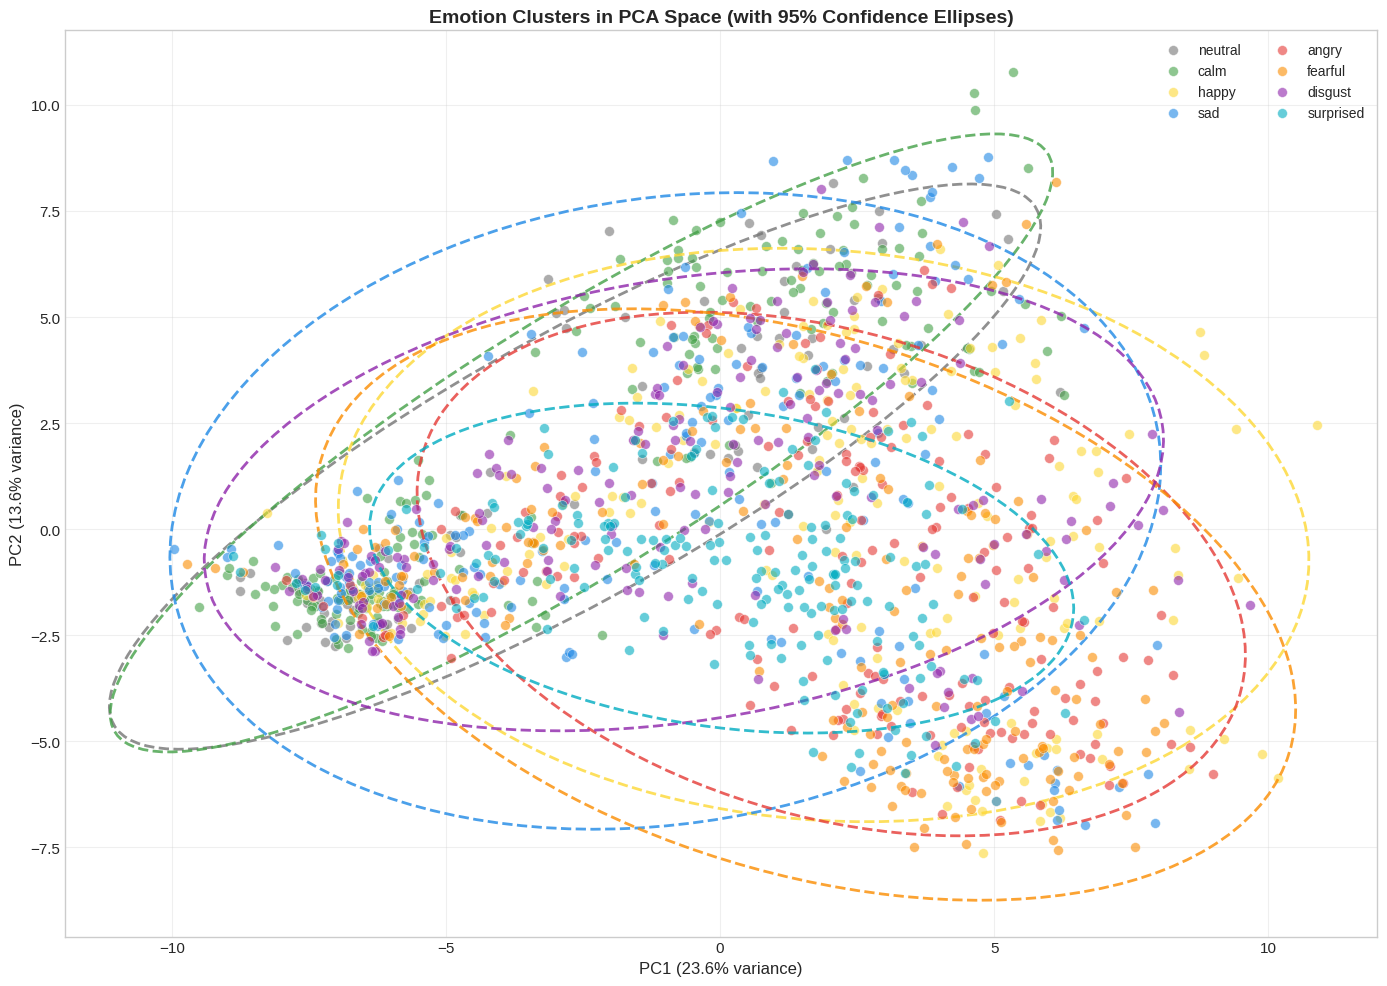


Total variance explained: 37.2%


In [13]:
# =============================================================================
# PCA VISUALIZATION WITH 95% CONFIDENCE ELLIPSES
# =============================================================================

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """Create a 95% confidence ellipse.
    
    Args:
        x (array-like): x-coordinates of the points.
        y (array-like): y-coordinates of the points.
        ax (matplotlib.axes.Axes): The axes on which to plot the ellipse.
        n_std (float): The number of standard deviations to use for the ellipse.
        facecolor (str): The color of the ellipse.
        **kwargs: Additional keyword arguments to pass to the Ellipse constructor.
    
    Returns:
        matplotlib.patches.Ellipse: The confidence ellipse.
    """
    if len(x) < 2:
        return None
    
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_x, mean_y = np.mean(x), np.mean(y)
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# PCA
pca_emotion = PCA(n_components=2, random_state=SEED)
X_pca = pca_emotion.fit_transform(X_scaled)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

for emotion in EMOTION_ORDER:
    mask = y_emotion == emotion
    color = EMOTION_COLORS[emotion]
    
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=emotion,
               alpha=0.6, s=50, edgecolors='white', linewidths=0.5)
    
    # Add confidence ellipse
    confidence_ellipse(X_pca[mask, 0], X_pca[mask, 1], ax,
                      edgecolor=color, linewidth=2, linestyle='--', alpha=0.8)

ax.set_xlabel(f'PC1 ({pca_emotion.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_emotion.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('Emotion Clusters in PCA Space (with 95% Confidence Ellipses)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'emotion_pca_ellipses.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTotal variance explained: {sum(pca_emotion.explained_variance_ratio_)*100:.1f}%")

Computing t-SNE embedding (this may take a minute)...


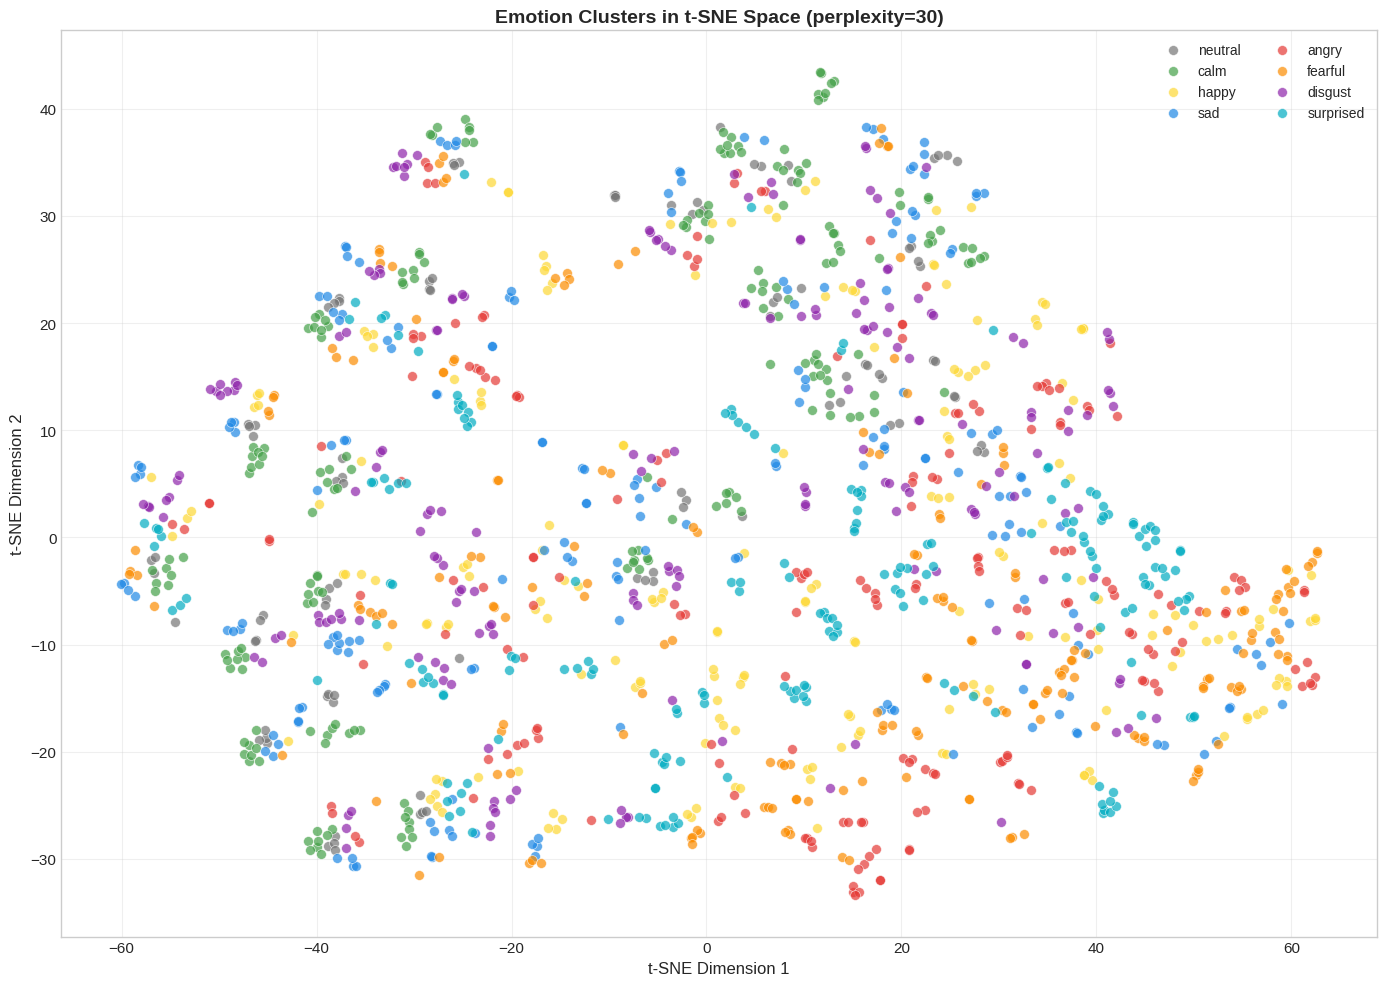

t-SNE embedding complete.


In [14]:
# =============================================================================
# t-SNE VISUALIZATION
# =============================================================================

print("Computing t-SNE embedding (this may take a minute)...")

# Note: 'n_iter' was renamed to 'max_iter' in scikit-learn 1.6+
tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

for emotion in EMOTION_ORDER:
    mask = y_emotion == emotion
    color = EMOTION_COLORS[emotion]
    
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, label=emotion,
               alpha=0.7, s=50, edgecolors='white', linewidths=0.5)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('Emotion Clusters in t-SNE Space (perplexity=30)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'emotion_tsne.png', dpi=150, bbox_inches='tight')
plt.show()

print("t-SNE embedding complete.")

Computing UMAP embedding...


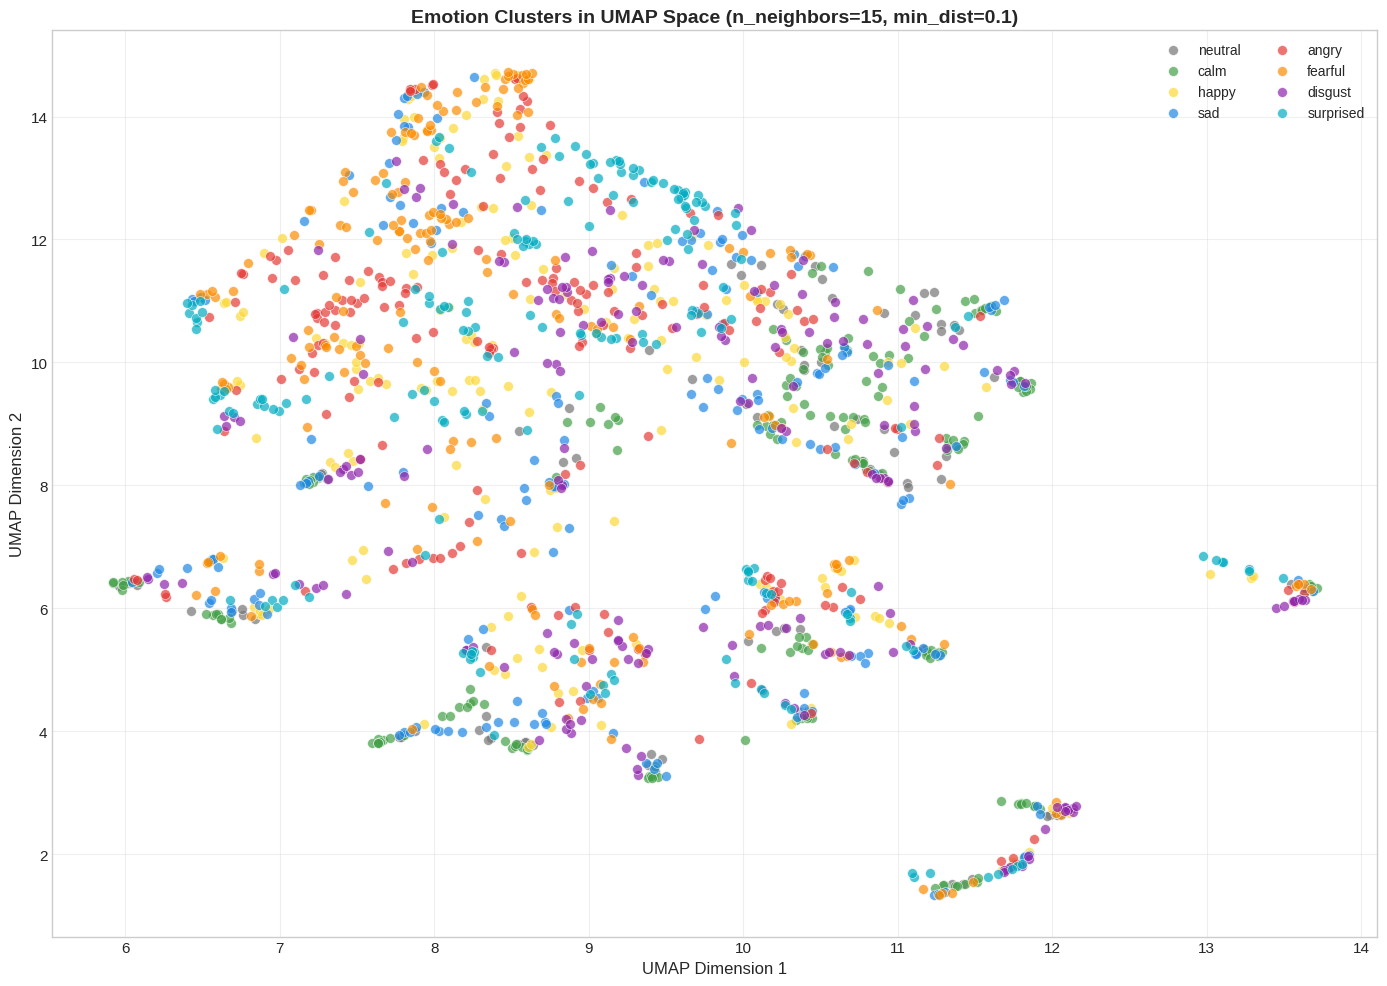

UMAP embedding complete.


In [15]:
# =============================================================================
# UMAP VISUALIZATION (If Available)
# =============================================================================

if UMAP_AVAILABLE:
    print("Computing UMAP embedding...")
    
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=SEED)
    X_umap = reducer.fit_transform(X_scaled)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 10))
    
    for emotion in EMOTION_ORDER:
        mask = y_emotion == emotion
        color = EMOTION_COLORS[emotion]
        
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1], c=color, label=emotion,
                   alpha=0.7, s=50, edgecolors='white', linewidths=0.5)
    
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    ax.set_title('Emotion Clusters in UMAP Space (n_neighbors=15, min_dist=0.1)', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, ncol=2)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'emotion_umap.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("UMAP embedding complete.")
else:
    print("UMAP not available. Skipping UMAP visualization.")
    print("Install with: pip install umap-learn")

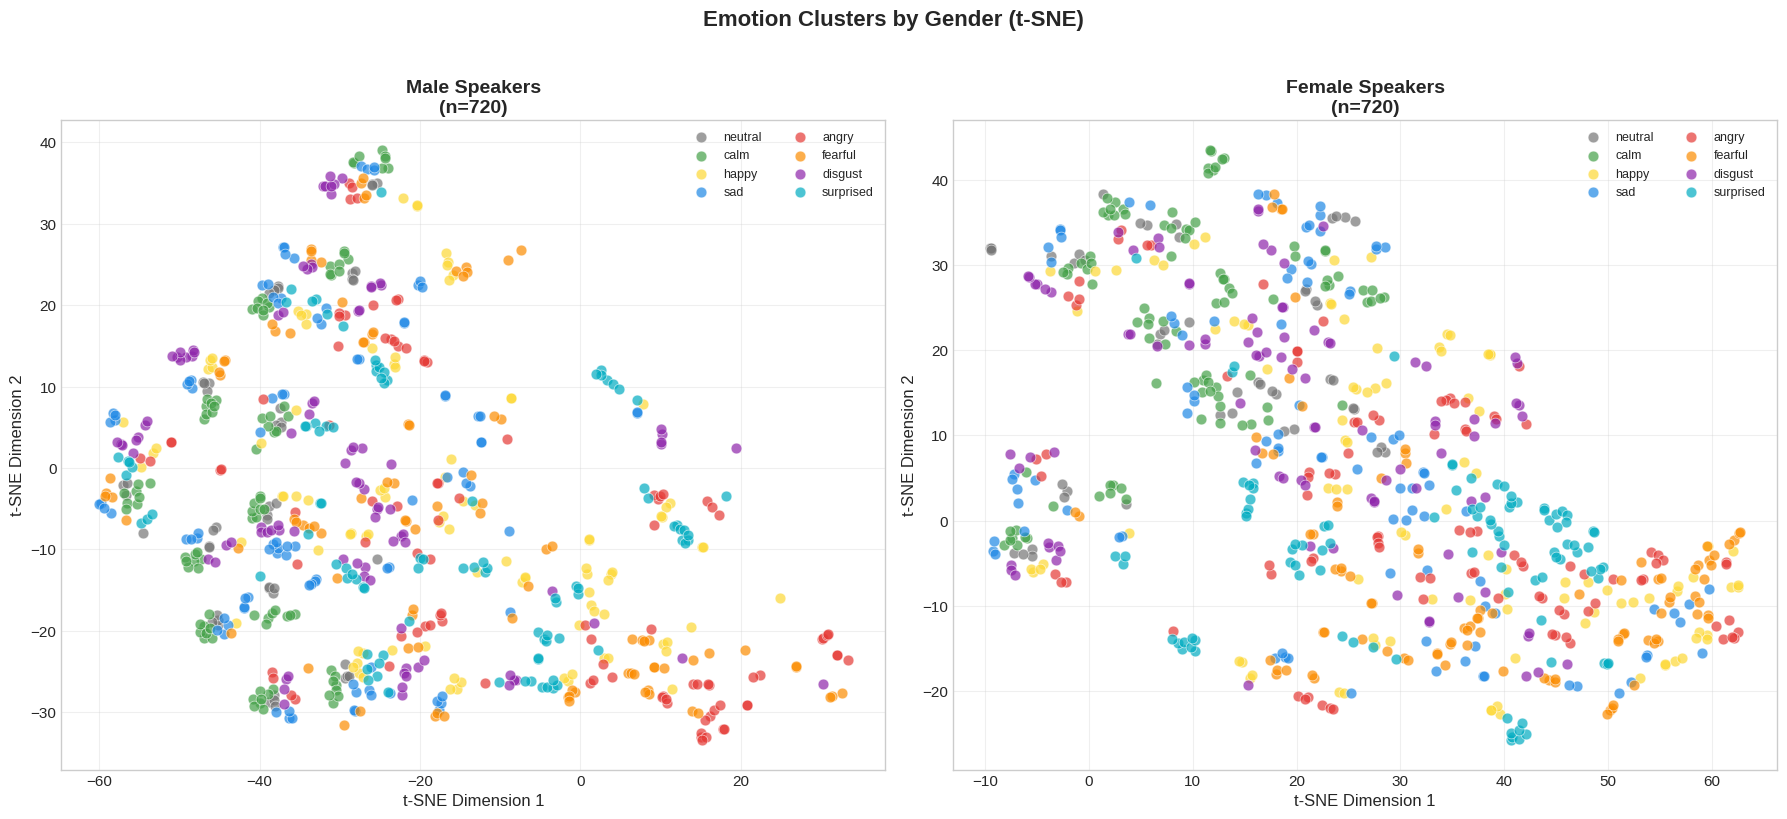

In [16]:
# =============================================================================
# GENDER-STRATIFIED EMOTION EMBEDDINGS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, gender in zip(axes, ['male', 'female']):
    gender_mask = y_gender == gender
    
    for emotion in EMOTION_ORDER:
        mask = (y_emotion == emotion) & gender_mask
        color = EMOTION_COLORS[emotion]
        
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, label=emotion,
                   alpha=0.7, s=60, edgecolors='white', linewidths=0.5)
    
    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.set_title(f'{gender.capitalize()} Speakers\n(n={gender_mask.sum()})', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3)

plt.suptitle('Emotion Clusters by Gender (t-SNE)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'emotion_tsne_by_gender.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Cross-Emotion Acoustic Distance Analysis

**Research Question**: Which emotion pairs are acoustically closest/farthest? Can we predict the confusion matrix structure from feature distances?

**Hypothesis**: Emotions with small feature-space distances will have higher confusion rates during classification.

**Methods**:
1. Compute centroid (mean feature vector) for each emotion
2. Calculate pairwise Euclidean distances between centroids
3. Visualize as heatmap and predict confusion patterns

In [17]:
# =============================================================================
# COMPUTE EMOTION CENTROIDS
# =============================================================================

# Use explicit list conversion for pandas compatibility
feature_cols = list(FEATURE_NAMES)

# Mean feature vector per emotion
emotion_centroids = df.groupby('emotion')[feature_cols].mean()

# Reorder by EMOTION_ORDER
emotion_centroids = emotion_centroids.loc[EMOTION_ORDER]

# Standardize centroids
centroids_scaled = scaler_all.transform(emotion_centroids)

print(f"Emotion centroid matrix shape: {emotion_centroids.shape}")
emotion_centroids.head()

Emotion centroid matrix shape: (8, 86)


mfcc_1_mean  mfcc_2_mean  mfcc_3_mean  mfcc_4_mean  mfcc_5_mean  \
emotion                                                                    
neutral  -679.331835    58.064828     2.769017    12.075057     4.746350   
calm     -685.864579    59.167877     4.718826    12.845901     5.460008   
happy    -554.136679    46.012288   -12.198635     6.229407     0.261652   
sad      -639.442081    54.128720    -1.898446    10.297733     3.787750   
angry    -478.452909    38.497447   -12.378559     4.554641    -4.399586   

         mfcc_6_mean  mfcc_7_mean  mfcc_8_mean  mfcc_9_mean  mfcc_10_mean  \
emotion                                                                     
neutral    -1.657703    -2.914273    -7.169071    -5.006971     -1.293349   
calm       -0.109152    -3.880095    -6.835961    -3.914849     -1.338550   
happy      -6.581204    -7.311591    -9.485679    -8.202483     -2.335009   
sad        -3.100695    -5.545570    -9.668555    -7.333188     -1.580992   
angry      -7.748399    -4.608495    -8.651540    -8.707544     -2.640061   

         mfcc_11_mean  mfcc_12_mean  mfcc_13_mean  mfcc_14_mean  mfcc_15_mean  \
emotion                                                                         
neutral     -2.045746     -2.357701     -1.304559     -1.002886     -2.038310   
calm        -1.433407     -2.824525     -1.911936     -1.027976     -2.061643   
happy       -4.148003     -3.657809     -2.229136     -1.251618     -2.280934   
sad         -3.473254     -3.647740     -1.173009     -1.296419     -1.248607   
angry       -3.527595     -3.758595     -2.111573     -1.962506     -2.895163   

         mfcc_16_mean  mfcc_17_mean  mfcc_18_mean  mfcc_19_mean  mfcc_20_mean  \
emotion                                                                         
neutral     -1.237337     -2.681209     -1.424928     -1.778153     -1.185711   
calm        -1.204604     -3.332690     -1.470200     -2.109305     -1.631948   
happy       -1.577193     -3.324357     -0.756638     -1.798990     -0.894367   
sad         -0.545278     -2.819569     -0.231298     -1.423548     -0.377439   
angry       -1.753030     -3.408449     -1.346621     -1.843499     -0.284613   

         mfcc_21_mean  mfcc_22_mean  mfcc_23_mean  mfcc_24_mean  mfcc_25_mean  \
emotion                                                                         
neutral     -3.006316     -0.719927     -2.982481     -0.730141     -2.233785   
calm        -3.403016     -0.845101     -3.482883     -0.675193     -2.628829   
happy       -2.023677      0.050192     -1.450865      0.834064     -0.478080   
sad         -2.184658     -0.092944     -2.196485      0.321901     -1.672982   
angry       -1.299168      0.832497     -0.942745      0.837991     -0.295248   

         ...  mfcc_22_std  mfcc_23_std  mfcc_24_std  mfcc_25_std  mfcc_26_std  \
emotion  ...                                                                    
neutral  ...     5.820159     7.142104     6.118732     6.509415     5.962676   
calm     ...     5.805375     7.009360     6.099227     6.877116     6.192771   
happy    ...     8.169598     9.244920     9.118869     8.976817     8.755128   
sad      ...     6.902218     7.660287     7.082617     7.610903     6.748220   
angry    ...     8.933426     9.419846     8.939307     8.993753     8.813392   

         mfcc_27_std  mfcc_28_std  mfcc_29_std  mfcc_30_std  mfcc_31_std  \
emotion                                                                    
neutral     7.221942     6.639632     7.199729     6.900588     6.911351   
calm        7.203940     6.526427     7.305392     7.093104     7.195147   
happy       8.878988     8.611269     8.558159     8.485328     8.310858   
sad         7.871479     6.822502     7.174728     7.042313     7.074212   
angry       8.667678     8.424336     8.337498     8.066621     7.743240   

         mfcc_32_std  mfcc_33_std  mfcc_34_std  mfcc_35_std  mfcc_36_std  \
emotion                                                

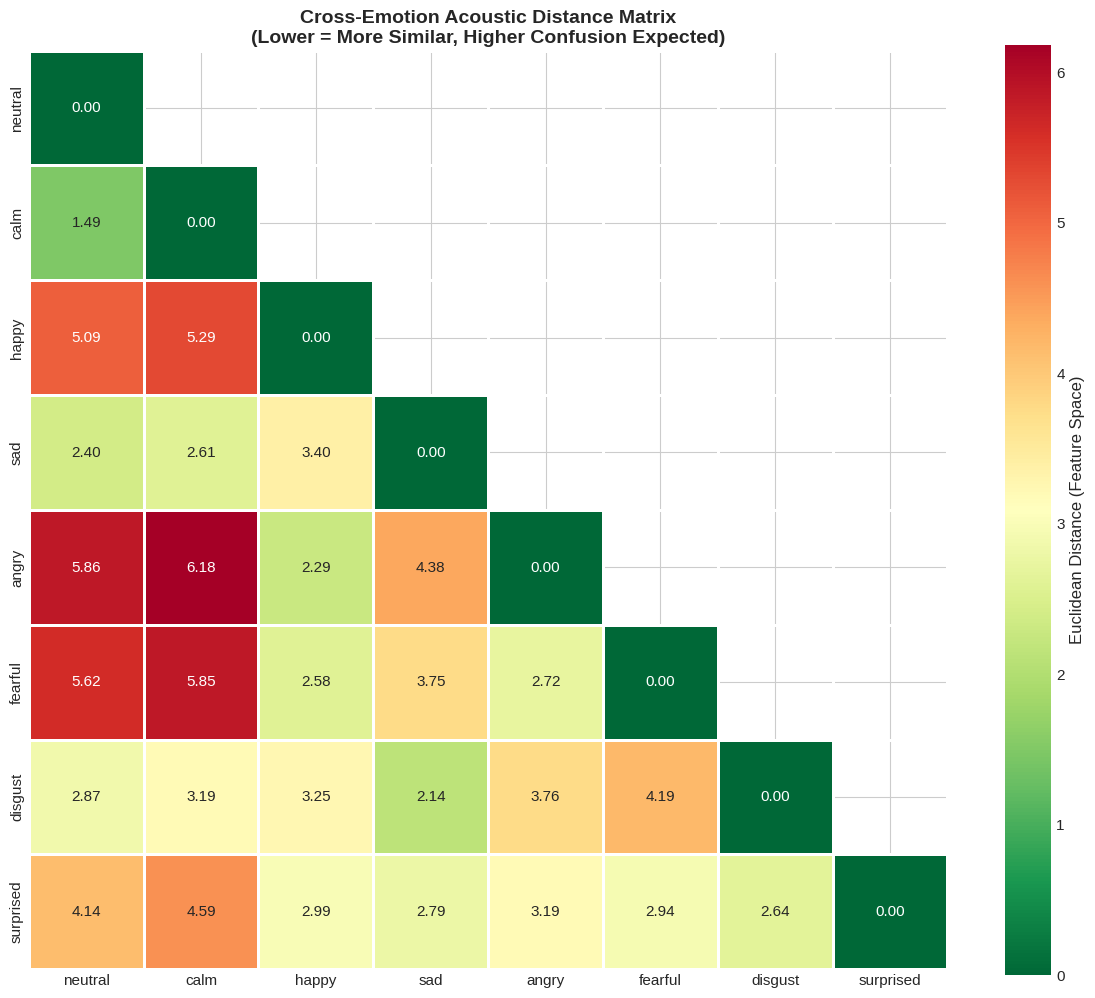


Distance matrix saved to /home/bjorn/repos/berkeley/DS207/EDFS/data/processed/bjorn_analysis/emotion_distances.csv


In [18]:
# =============================================================================
# PAIRWISE DISTANCE HEATMAP
# =============================================================================

# Compute pairwise Euclidean distances
distances = squareform(pdist(centroids_scaled, metric='euclidean'))
distance_df = pd.DataFrame(distances, index=EMOTION_ORDER, columns=EMOTION_ORDER)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(distance_df, dtype=bool), k=1)  # Upper triangle

sns.heatmap(distance_df, annot=True, fmt='.2f', cmap='RdYlGn_r',
            mask=mask, square=True, linewidths=1,
            cbar_kws={'label': 'Euclidean Distance (Feature Space)'}, ax=ax)

ax.set_title('Cross-Emotion Acoustic Distance Matrix\n(Lower = More Similar, Higher Confusion Expected)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'emotion_distance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Save distance matrix
distance_df.to_csv(OUTPUT_PATH / 'emotion_distances.csv')
print(f"\nDistance matrix saved to {OUTPUT_PATH / 'emotion_distances.csv'}")

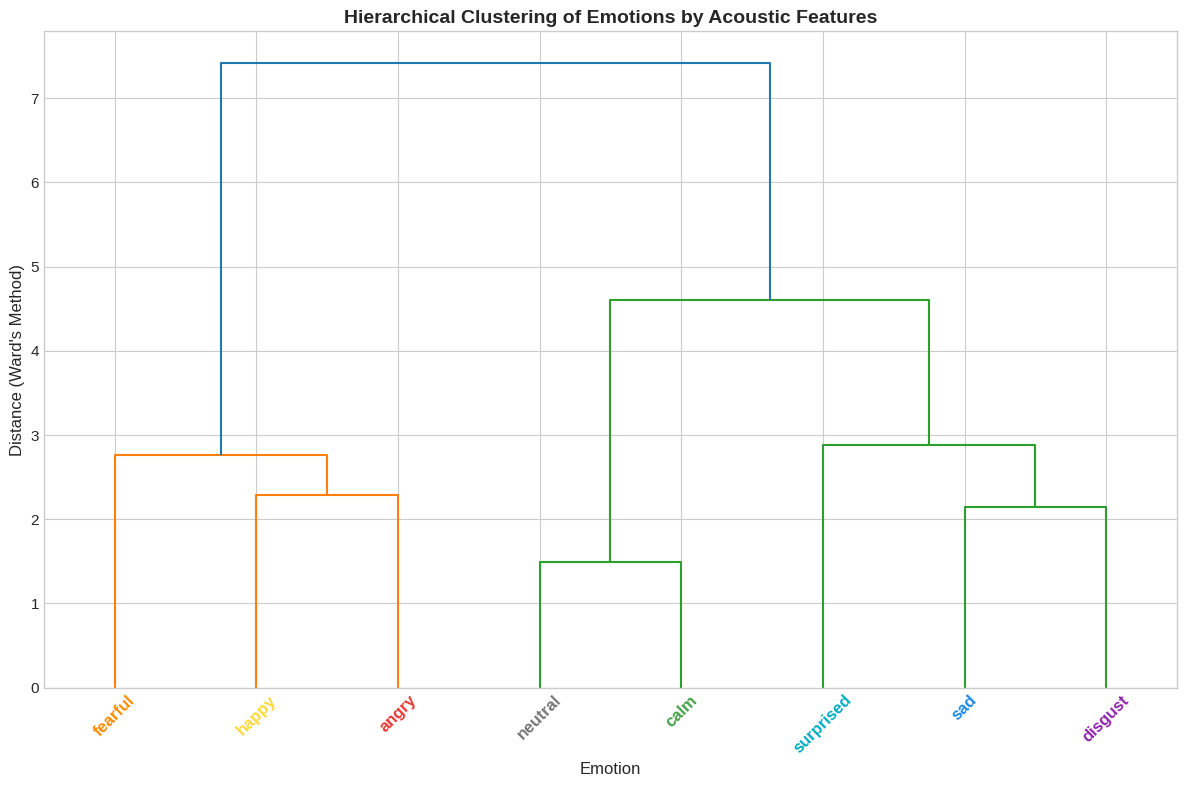

In [19]:
# =============================================================================
# EMOTION DENDROGRAM
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Hierarchical clustering
linkage_emotions = linkage(centroids_scaled, method='ward')

dendro = dendrogram(
    linkage_emotions,
    labels=EMOTION_ORDER,
    leaf_rotation=45,
    leaf_font_size=12,
    ax=ax
)

# Color labels by emotion
ax_labels = ax.get_xticklabels()
for label in ax_labels:
    emotion = label.get_text()
    label.set_color(EMOTION_COLORS.get(emotion, 'black'))
    label.set_fontweight('bold')

ax.set_title('Hierarchical Clustering of Emotions by Acoustic Features', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Distance (Ward\'s Method)', fontsize=12)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'emotion_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

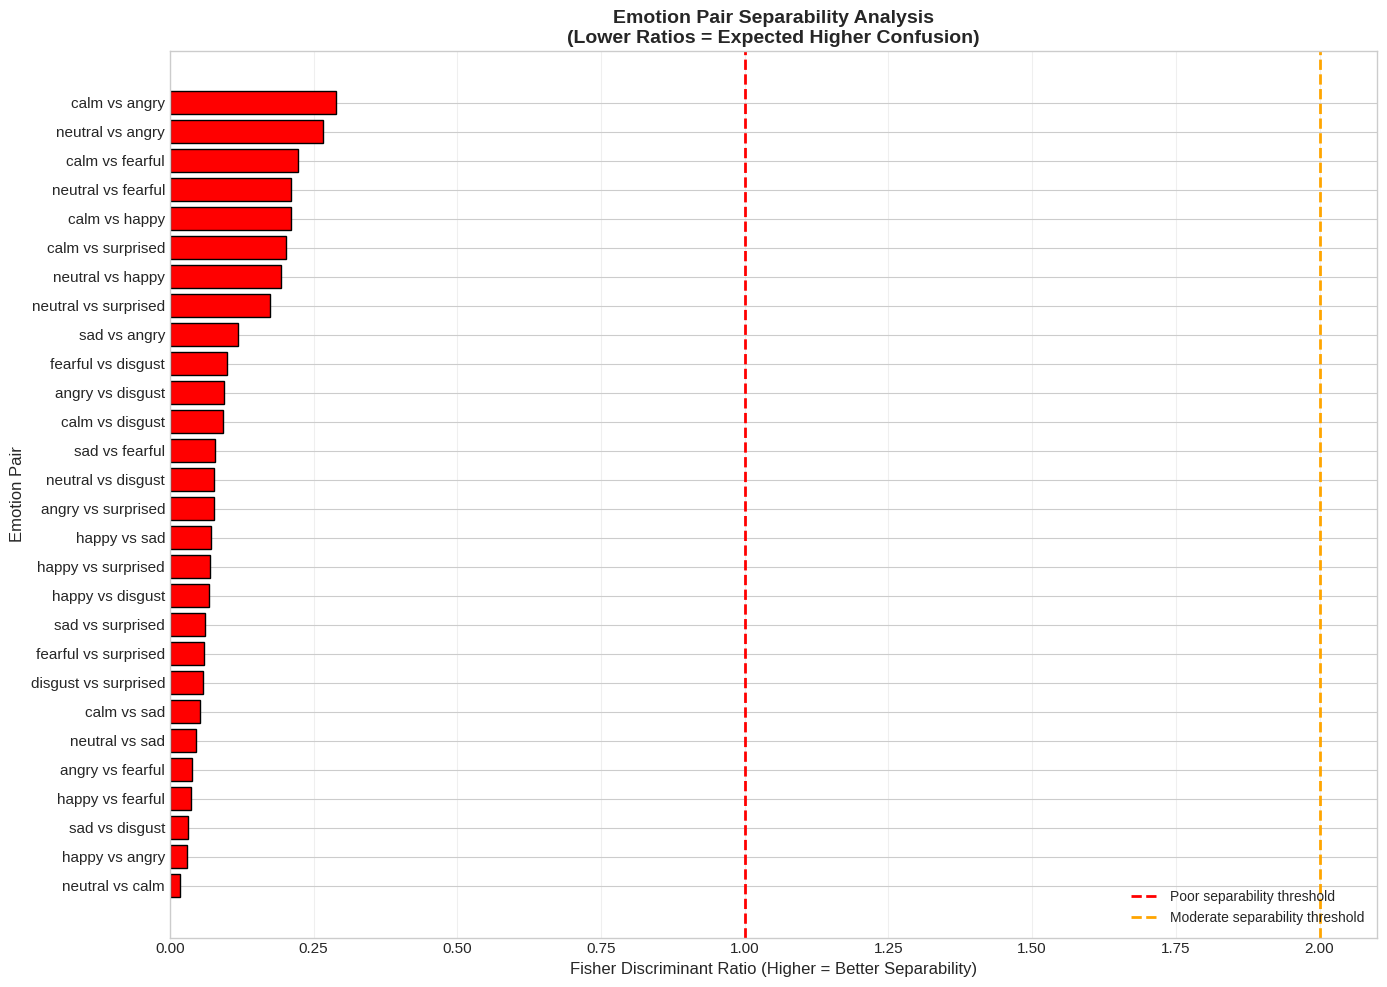


=== LOWEST SEPARABILITY PAIRS (Expect High Confusion) ===
            pair emotion1 emotion2  fisher_ratio
 neutral vs calm  neutral     calm      0.017147
  happy vs angry    happy    angry      0.030403
  sad vs disgust      sad  disgust      0.032149
happy vs fearful    happy  fearful      0.036168
angry vs fearful    angry  fearful      0.038796


In [20]:
# =============================================================================
# FISHER DISCRIMINANT RATIO (Class Separability)
# =============================================================================

def compute_fisher_ratio(X1: np.ndarray, X2: np.ndarray) -> float:
    """Compute Fisher discriminant ratio between two classes.
    
    Higher ratio = better separability.

    Args:
        X1 (np.ndarray): Features for class 1.
        X2 (np.ndarray): Features for class 2.
    
    Returns:
        float: Fisher discriminant ratio.
    """
    mean_diff = np.mean(X1, axis=0) - np.mean(X2, axis=0)
    var_sum = np.var(X1, axis=0) + np.var(X2, axis=0)
    
    # Avoid division by zero
    var_sum = np.where(var_sum == 0, 1e-10, var_sum)
    
    return np.mean(mean_diff**2 / var_sum)

# Compute Fisher ratio for all emotion pairs
fisher_ratios = {}
emotion_pairs = []

for i, e1 in enumerate(EMOTION_ORDER):
    for e2 in EMOTION_ORDER[i+1:]:
        X1 = X_scaled[y_emotion == e1]
        X2 = X_scaled[y_emotion == e2]
        
        ratio = compute_fisher_ratio(X1, X2)
        pair = f"{e1} vs {e2}"
        fisher_ratios[pair] = ratio
        emotion_pairs.append({'pair': pair, 'emotion1': e1, 'emotion2': e2, 'fisher_ratio': ratio})

fisher_df = pd.DataFrame(emotion_pairs).sort_values('fisher_ratio', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

colors = ['red' if r < 1 else 'orange' if r < 2 else 'green' 
          for r in fisher_df['fisher_ratio']]

bars = ax.barh(fisher_df['pair'], fisher_df['fisher_ratio'], color=colors, edgecolor='black')

ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Poor separability threshold')
ax.axvline(x=2, color='orange', linestyle='--', linewidth=2, label='Moderate separability threshold')

ax.set_xlabel('Fisher Discriminant Ratio (Higher = Better Separability)', fontsize=12)
ax.set_ylabel('Emotion Pair', fontsize=12)
ax.set_title('Emotion Pair Separability Analysis\n(Lower Ratios = Expected Higher Confusion)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'emotion_separability.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== LOWEST SEPARABILITY PAIRS (Expect High Confusion) ===")
print(fisher_df.head(5).to_string(index=False))

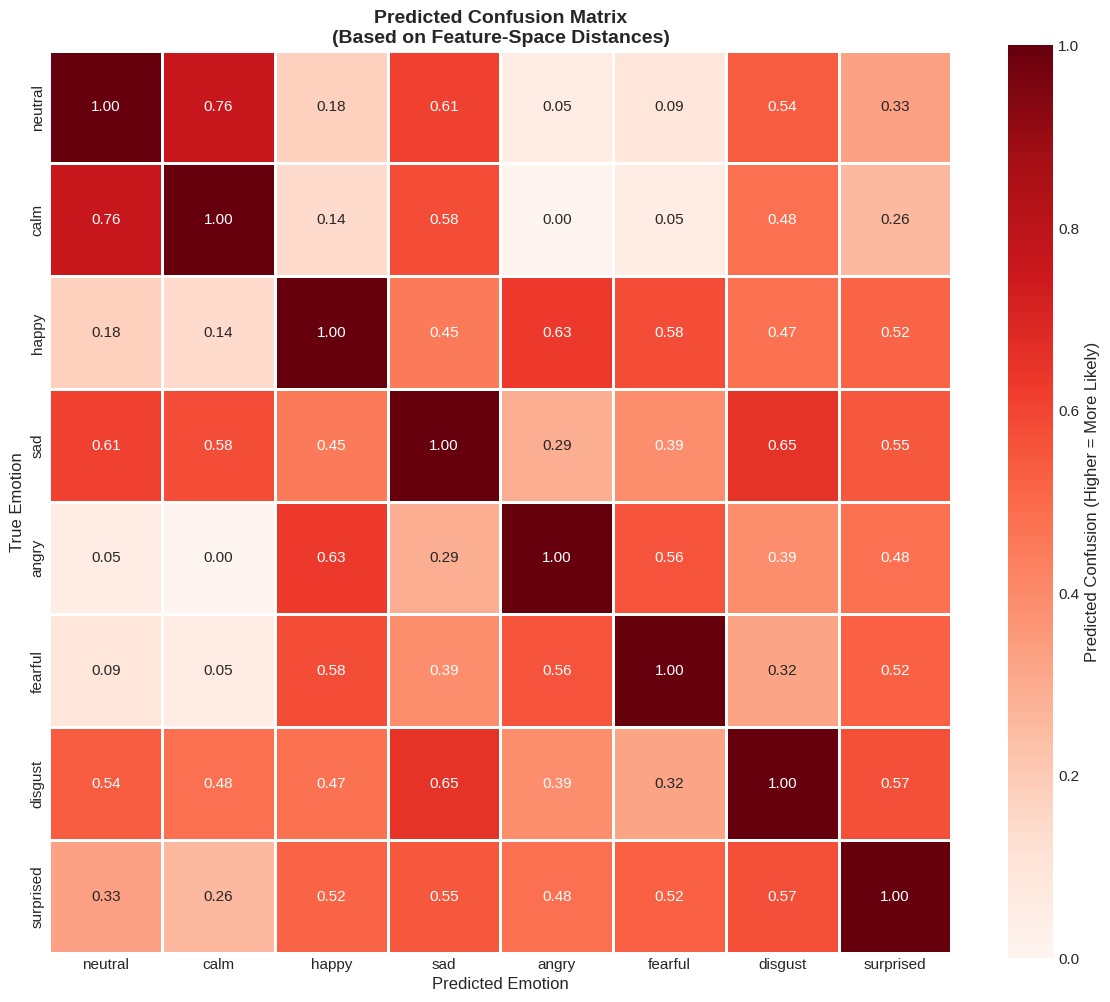


=== PREDICTED HIGH-CONFUSION PAIRS ===
(To be validated against actual model confusion matrices)


In [21]:
# =============================================================================
# PREDICTED CONFUSION MATRIX (Based on Distances)
# =============================================================================

# Convert distances to pseudo-probabilities (inverse relationship)
# Lower distance = higher confusion probability
max_dist = distance_df.max().max()
confusion_pred = 1 - (distance_df / max_dist)

# Set diagonal to 1 (perfect self-classification baseline)
np.fill_diagonal(confusion_pred.values, 1.0)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(confusion_pred, annot=True, fmt='.2f', cmap='Reds',
            square=True, linewidths=1, vmin=0, vmax=1,
            cbar_kws={'label': 'Predicted Confusion (Higher = More Likely)'}, ax=ax)

ax.set_title('Predicted Confusion Matrix\n(Based on Feature-Space Distances)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Emotion', fontsize=12)
ax.set_ylabel('True Emotion', fontsize=12)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'predicted_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== PREDICTED HIGH-CONFUSION PAIRS ===")
print("(To be validated against actual model confusion matrices)")

## 6. Emotional Intensity Effect Quantification

**Research Question**: How much does emotional intensity (normal vs. strong) affect acoustic features? Which features are most intensity-sensitive?

**Note**: Neutral emotion has no intensity variation (always "normal"), so we analyze the 7 non-neutral emotions.

**Methods**:
1. For each feature, compute effect size (Cohen's d) between normal and strong intensity
2. Perform statistical tests (Welch's t-test) with Bonferroni correction
3. Identify features most affected by intensity

In [22]:
# =============================================================================
# PREPARE INTENSITY COMPARISON DATA
# =============================================================================

# Filter to non-neutral emotions (which have intensity variations)
df_intensity = df[df['emotion'] != 'neutral'].copy()

print(f"Non-neutral samples: {len(df_intensity)}")
print(f"\nIntensity distribution:")
print(df_intensity['intensity'].value_counts())
print(f"\nIntensity by emotion:")
print(pd.crosstab(df_intensity['emotion'], df_intensity['intensity']))

Non-neutral samples: 1344

Intensity distribution:
intensity
normal    672
strong    672
Name: count, dtype: int64

Intensity by emotion:
intensity  normal  strong
emotion                  
angry          96      96
calm           96      96
disgust        96      96
fearful        96      96
happy          96      96
sad            96      96
surprised      96      96


In [23]:
# =============================================================================
# COMPUTE COHEN'S D EFFECT SIZES
# =============================================================================

def cohens_d(group1: np.ndarray, group2: np.ndarray) -> float:
    """Compute Cohen's d effect size between two groups.
    
    Interpretation:
    - |d| < 0.2: negligible
    - 0.2 <= |d| < 0.5: small
    - 0.5 <= |d| < 0.8: medium
    - |d| >= 0.8: large

    Args:
        group1 (np.ndarray): Features for group 1.
        group2 (np.ndarray): Features for group 2.
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    
    if pooled_std == 0:
        return 0
    
    return (np.mean(group1) - np.mean(group2)) / pooled_std

# Compute effect sizes for each emotion x feature combination
emotions_with_intensity = [e for e in EMOTION_ORDER if e != 'neutral']
effect_sizes = []

for emotion in emotions_with_intensity:
    df_emotion = df_intensity[df_intensity['emotion'] == emotion]
    df_normal = df_emotion[df_emotion['intensity'] == 'normal']
    df_strong = df_emotion[df_emotion['intensity'] == 'strong']
    
    for feature in FEATURE_NAMES:
        d = cohens_d(df_strong[feature].values, df_normal[feature].values)
        effect_sizes.append({
            'emotion': emotion,
            'feature': feature,
            'cohens_d': d
        })

effect_df = pd.DataFrame(effect_sizes)
effect_pivot = effect_df.pivot(index='feature', columns='emotion', values='cohens_d')
effect_pivot = effect_pivot[emotions_with_intensity]  # Reorder columns

print(f"Effect size matrix shape: {effect_pivot.shape}")

Effect size matrix shape: (86, 7)


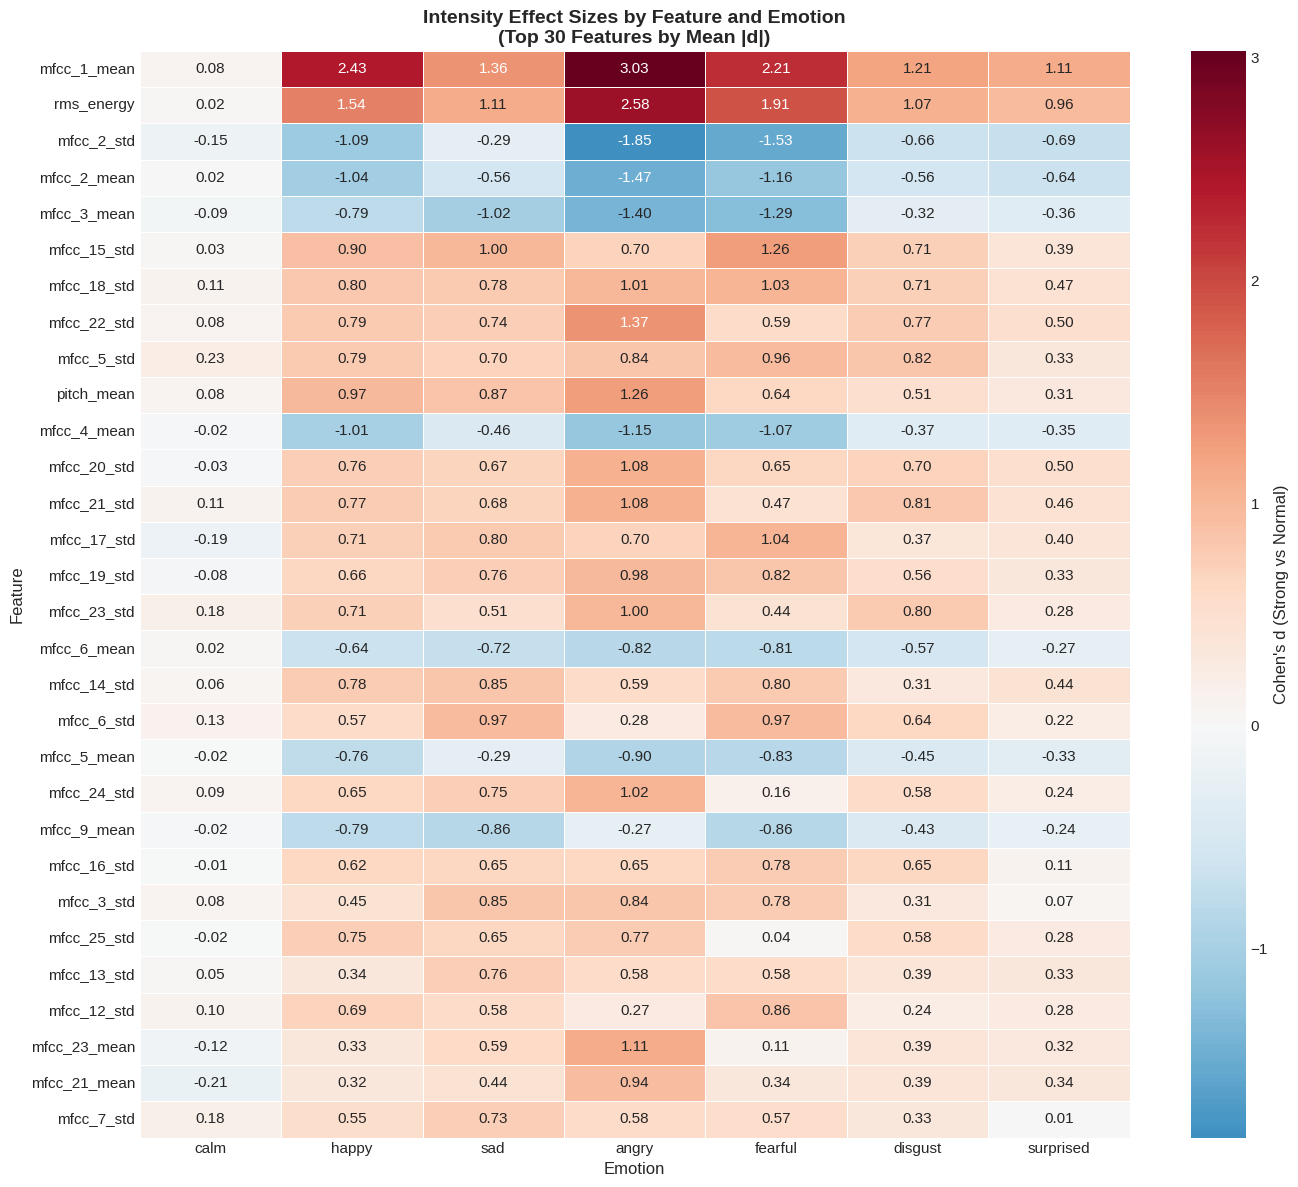

Effect sizes saved to /home/bjorn/repos/berkeley/DS207/EDFS/data/processed/bjorn_analysis/intensity_effect_sizes.csv


In [24]:
# =============================================================================
# EFFECT SIZE HEATMAP
# =============================================================================

# Select top features by mean absolute effect size
mean_abs_effect = effect_pivot.abs().mean(axis=1).sort_values(ascending=False)
top_features = mean_abs_effect.head(30).index.tolist()

fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(effect_pivot.loc[top_features], annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, linewidths=0.5,
            cbar_kws={'label': "Cohen's d (Strong vs Normal)"}, ax=ax)

ax.set_title('Intensity Effect Sizes by Feature and Emotion\n(Top 30 Features by Mean |d|)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'intensity_effect_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Save effect sizes
effect_df.to_csv(OUTPUT_PATH / 'intensity_effect_sizes.csv', index=False)
print(f"Effect sizes saved to {OUTPUT_PATH / 'intensity_effect_sizes.csv'}")

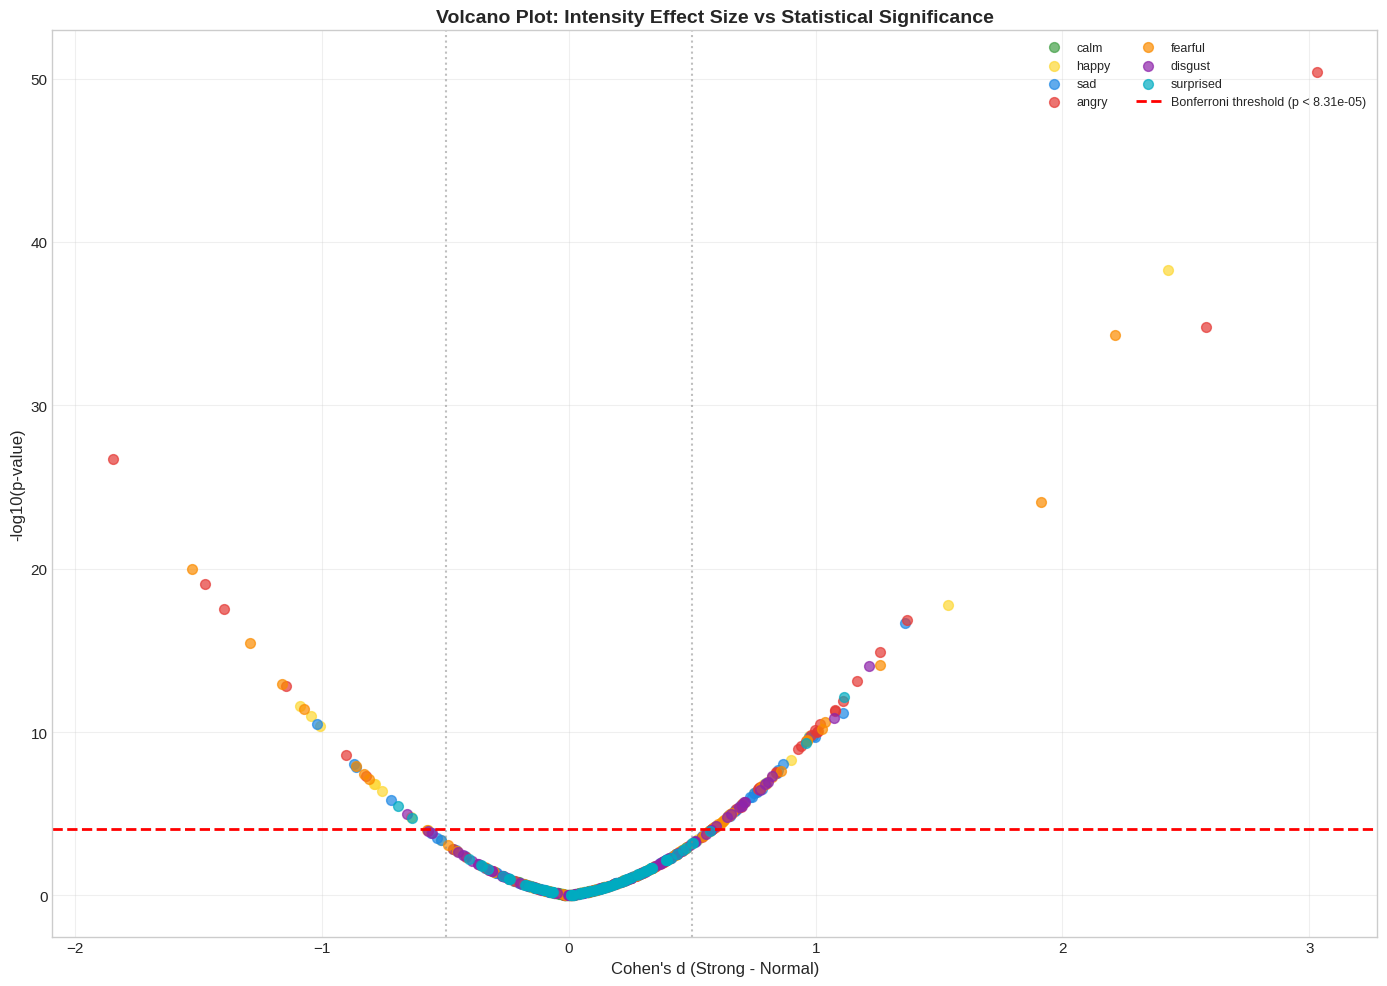


Significant results (Bonferroni corrected): 132/602 (21.9%)


In [25]:
# =============================================================================
# VOLCANO PLOT (Effect Size vs Statistical Significance)
# =============================================================================

# Compute p-values using Welch's t-test
results = []

for emotion in emotions_with_intensity:
    df_emotion = df_intensity[df_intensity['emotion'] == emotion]
    df_normal = df_emotion[df_emotion['intensity'] == 'normal']
    df_strong = df_emotion[df_emotion['intensity'] == 'strong']
    
    for feature in FEATURE_NAMES:
        d = cohens_d(df_strong[feature].values, df_normal[feature].values)
        _, p = stats.ttest_ind(df_strong[feature].values, df_normal[feature].values, 
                               equal_var=False)  # Welch's t-test
        
        results.append({
            'emotion': emotion,
            'feature': feature,
            'cohens_d': d,
            'p_value': p,
            'neg_log_p': -np.log10(p) if p > 0 else 10
        })

results_df = pd.DataFrame(results)

# Bonferroni correction threshold
n_tests = len(results_df)
bonferroni_threshold = 0.05 / n_tests
significance_line = -np.log10(bonferroni_threshold)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

for emotion in emotions_with_intensity:
    mask = results_df['emotion'] == emotion
    color = EMOTION_COLORS[emotion]
    
    ax.scatter(results_df.loc[mask, 'cohens_d'], 
               results_df.loc[mask, 'neg_log_p'],
               c=color, label=emotion, alpha=0.7, s=50)

ax.axhline(y=significance_line, color='red', linestyle='--', linewidth=2,
           label=f'Bonferroni threshold (p < {bonferroni_threshold:.2e})')
ax.axvline(x=-0.5, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel("Cohen's d (Strong - Normal)", fontsize=12)
ax.set_ylabel('-log10(p-value)', fontsize=12)
ax.set_title('Volcano Plot: Intensity Effect Size vs Statistical Significance', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'intensity_volcano_plot.png', dpi=150, bbox_inches='tight')
plt.show()

# Count significant results
n_significant = (results_df['p_value'] < bonferroni_threshold).sum()
print(f"\nSignificant results (Bonferroni corrected): {n_significant}/{len(results_df)} ({100*n_significant/len(results_df):.1f}%)")

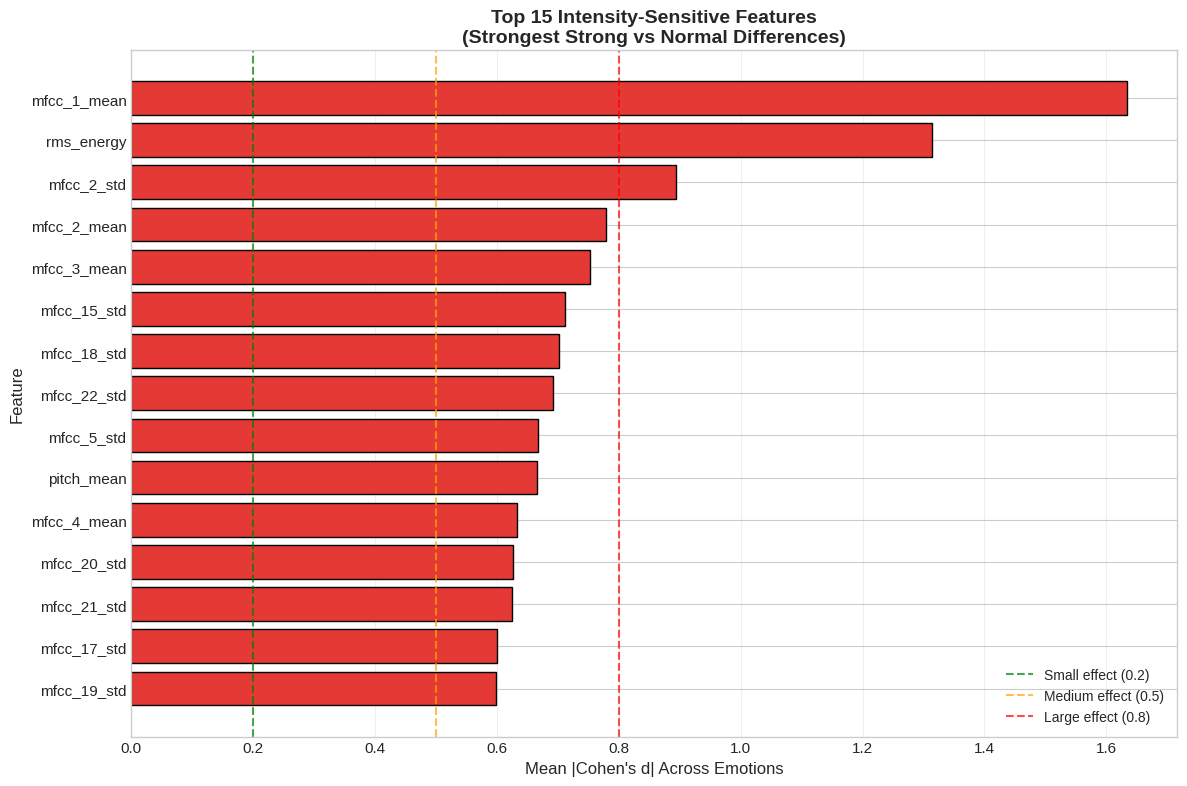


=== TOP 10 INTENSITY-SENSITIVE FEATURES ===
1. mfcc_1_mean: |d| = 1.634
2. rms_energy: |d| = 1.314
3. mfcc_2_std: |d| = 0.894
4. mfcc_2_mean: |d| = 0.778
5. mfcc_3_mean: |d| = 0.752
6. mfcc_15_std: |d| = 0.712
7. mfcc_18_std: |d| = 0.702
8. mfcc_22_std: |d| = 0.692
9. mfcc_5_std: |d| = 0.667
10. pitch_mean: |d| = 0.665


In [26]:
# =============================================================================
# TOP INTENSITY-SENSITIVE FEATURES
# =============================================================================

# Average absolute Cohen's d across emotions for each feature
feature_intensity_sensitivity = effect_pivot.abs().mean(axis=1).sort_values(ascending=False)

# Plot top 15
fig, ax = plt.subplots(figsize=(12, 8))

top_15 = feature_intensity_sensitivity.head(15)
colors = ['#E53935' if v > 0.5 else '#FB8C00' if v > 0.3 else '#43A047' for v in top_15]

bars = ax.barh(top_15.index[::-1], top_15.values[::-1], color=colors[::-1], edgecolor='black')

ax.axvline(x=0.2, color='green', linestyle='--', alpha=0.7, label='Small effect (0.2)')
ax.axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium effect (0.5)')
ax.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Large effect (0.8)')

ax.set_xlabel("Mean |Cohen's d| Across Emotions", fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Top 15 Intensity-Sensitive Features\n(Strongest Strong vs Normal Differences)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'top_intensity_features.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== TOP 10 INTENSITY-SENSITIVE FEATURES ===")
for i, (feat, val) in enumerate(feature_intensity_sensitivity.head(10).items(), 1):
    print(f"{i}. {feat}: |d| = {val:.3f}")

## 7. Temporal Feature Evolution Within Utterances

**Research Question**: How do acoustic features evolve over the course of an utterance? Do different emotions have distinct temporal signatures?

**Why This Matters**: Time-averaged features (used by Pratheek and Nithya) discard temporal dynamics. Emotions may be characterized by:
- Rising/falling pitch contours
- Energy envelopes (attack, sustain, decay)
- Spectral changes over time

This analysis informs whether sequence models (LSTM, Transformer) might outperform static feature classifiers.

In [27]:
# =============================================================================
# EXTRACT FRAME-LEVEL FEATURES
# =============================================================================

def extract_temporal_features(filepath: str, sr: int = SAMPLE_RATE, 
                              hop_length: int = HOP_LENGTH) -> dict:
    """Extract frame-level features for temporal analysis.
    
    Args:
        filepath (str): Path to audio file.
        sr (int): Sample rate.
        hop_length (int): Hop length.
    
    Returns:
        Dictionary with time series for pitch, energy, spectral centroid, MFCC1
    """
    try:
        y, sr = librosa.load(filepath, sr=sr)
        
        # Pitch (F0) using YIN - frame level
        f0 = librosa.yin(y, fmin=50, fmax=400, sr=sr, hop_length=hop_length)
        
        # RMS Energy - frame level
        rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
        
        # Spectral centroid - frame level
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)[0]
        
        # MFCC1 (first coefficient, related to overall energy) - frame level
        mfcc1 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=1, hop_length=hop_length)[0]
        
        return {
            'pitch': f0,
            'energy': rms,
            'centroid': centroid,
            'mfcc1': mfcc1
        }
        
    except Exception as e:
        return None

print("Extracting temporal features from all files...")
print("This will take several minutes.\n")

temporal_data = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting temporal features"):
    features = extract_temporal_features(row['filepath'])
    
    if features is not None:
        temporal_data.append({
            'index': idx,
            'emotion': row['emotion'],
            'gender': row['gender'],
            **features
        })

print(f"\nExtracted temporal features from {len(temporal_data)} files.")

Extracting temporal features from all files...
This will take several minutes.



Extracting temporal features:   0%|          | 0/1440 [00:00<?, ?it/s]


Extracted temporal features from 1440 files.


In [28]:
# =============================================================================
# INTERPOLATE TO FIXED LENGTH (100 time steps)
# =============================================================================

TARGET_LENGTH = 100

def interpolate_to_fixed_length(arr: np.ndarray, target_length: int = TARGET_LENGTH) -> np.ndarray:
    """Interpolate array to fixed length.
    
    Args:
        arr (np.ndarray): Input array.
        target_length (int): Target length.
    
    Returns:
        np.ndarray: Interpolated array.
    """
    if len(arr) == 0:
        return np.zeros(target_length)
    
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, target_length)
    
    f = interp1d(x_old, arr, kind='linear', fill_value='extrapolate')
    return f(x_new)

# Normalize all temporal sequences to same length
for item in temporal_data:
    item['pitch_norm'] = interpolate_to_fixed_length(item['pitch'])
    item['energy_norm'] = interpolate_to_fixed_length(item['energy'])
    item['centroid_norm'] = interpolate_to_fixed_length(item['centroid'])
    item['mfcc1_norm'] = interpolate_to_fixed_length(item['mfcc1'])

print(f"Normalized all sequences to {TARGET_LENGTH} time steps.")

Normalized all sequences to 100 time steps.


In [29]:
# =============================================================================
# AVERAGE TEMPORAL PROFILES BY EMOTION
# =============================================================================

# Group by emotion and compute mean temporal profiles
temporal_by_emotion = {}

for emotion in EMOTION_ORDER:
    emotion_data = [d for d in temporal_data if d['emotion'] == emotion]
    
    temporal_by_emotion[emotion] = {
        'pitch': np.mean([d['pitch_norm'] for d in emotion_data], axis=0),
        'pitch_std': np.std([d['pitch_norm'] for d in emotion_data], axis=0),
        'energy': np.mean([d['energy_norm'] for d in emotion_data], axis=0),
        'energy_std': np.std([d['energy_norm'] for d in emotion_data], axis=0),
        'centroid': np.mean([d['centroid_norm'] for d in emotion_data], axis=0),
        'mfcc1': np.mean([d['mfcc1_norm'] for d in emotion_data], axis=0),
        'n_samples': len(emotion_data)
    }

print("Computed average temporal profiles for each emotion.")

Computed average temporal profiles for each emotion.


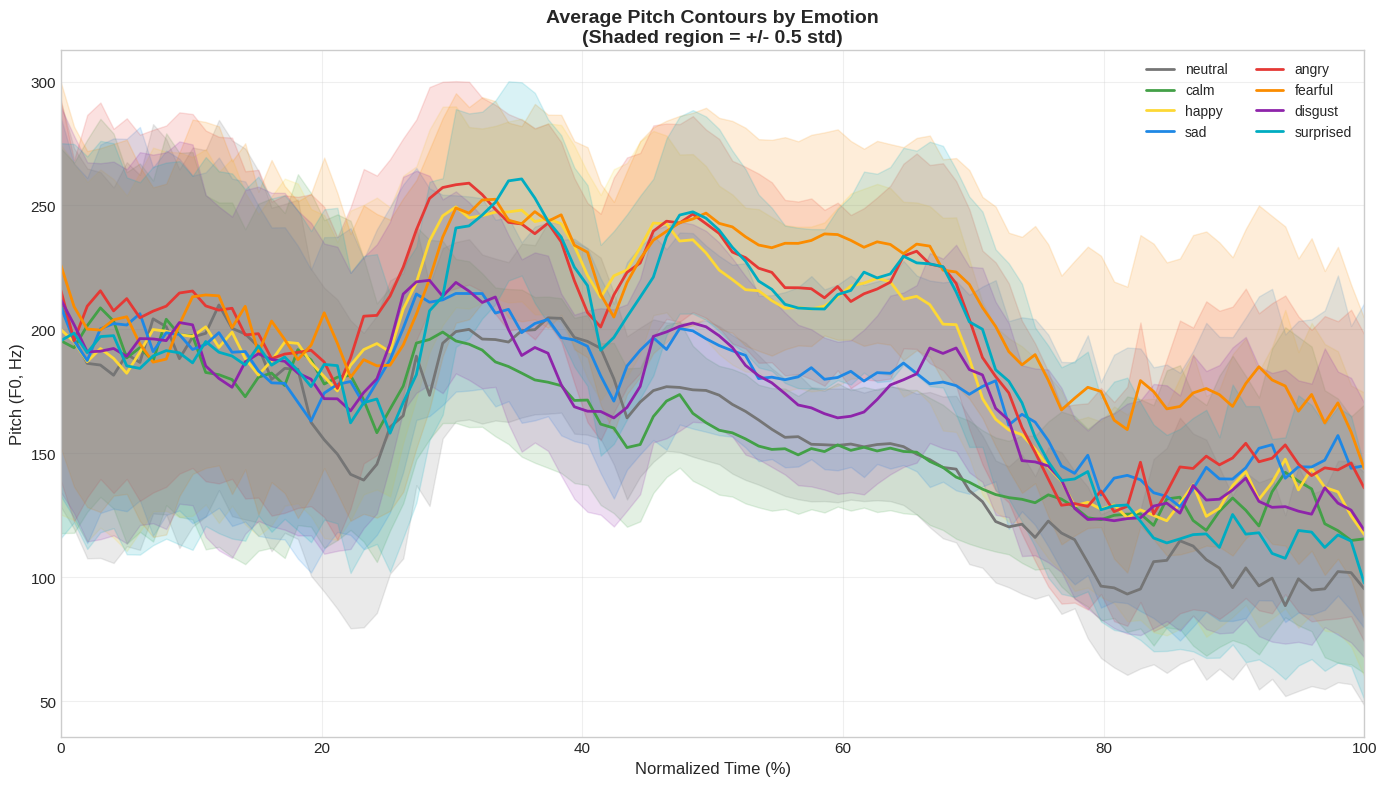

In [30]:
# =============================================================================
# PITCH (F0) CONTOUR COMPARISON
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

time_axis = np.linspace(0, 100, TARGET_LENGTH)

for emotion in EMOTION_ORDER:
    color = EMOTION_COLORS[emotion]
    data = temporal_by_emotion[emotion]
    
    ax.plot(time_axis, data['pitch'], color=color, linewidth=2, label=emotion)
    ax.fill_between(time_axis, 
                    data['pitch'] - data['pitch_std']/2,
                    data['pitch'] + data['pitch_std']/2,
                    color=color, alpha=0.15)

ax.set_xlabel('Normalized Time (%)', fontsize=12)
ax.set_ylabel('Pitch (F0, Hz)', fontsize=12)
ax.set_title('Average Pitch Contours by Emotion\n(Shaded region = +/- 0.5 std)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'pitch_contours.png', dpi=150, bbox_inches='tight')
plt.show()

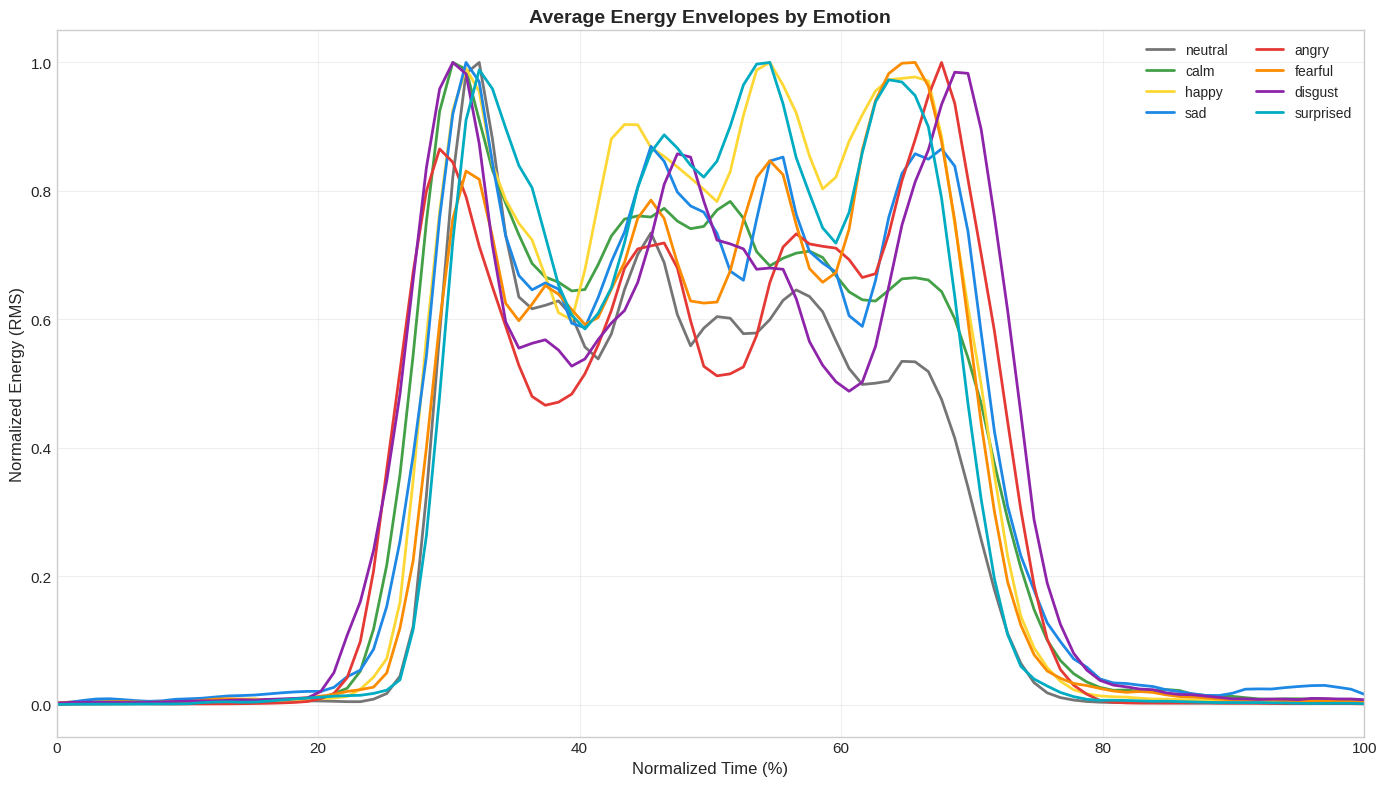

In [31]:
# =============================================================================
# ENERGY ENVELOPE COMPARISON
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

for emotion in EMOTION_ORDER:
    color = EMOTION_COLORS[emotion]
    data = temporal_by_emotion[emotion]
    
    # Normalize energy for comparison
    energy_norm = data['energy'] / np.max(data['energy'])
    
    ax.plot(time_axis, energy_norm, color=color, linewidth=2, label=emotion)

ax.set_xlabel('Normalized Time (%)', fontsize=12)
ax.set_ylabel('Normalized Energy (RMS)', fontsize=12)
ax.set_title('Average Energy Envelopes by Emotion', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'energy_envelopes.png', dpi=150, bbox_inches='tight')
plt.show()

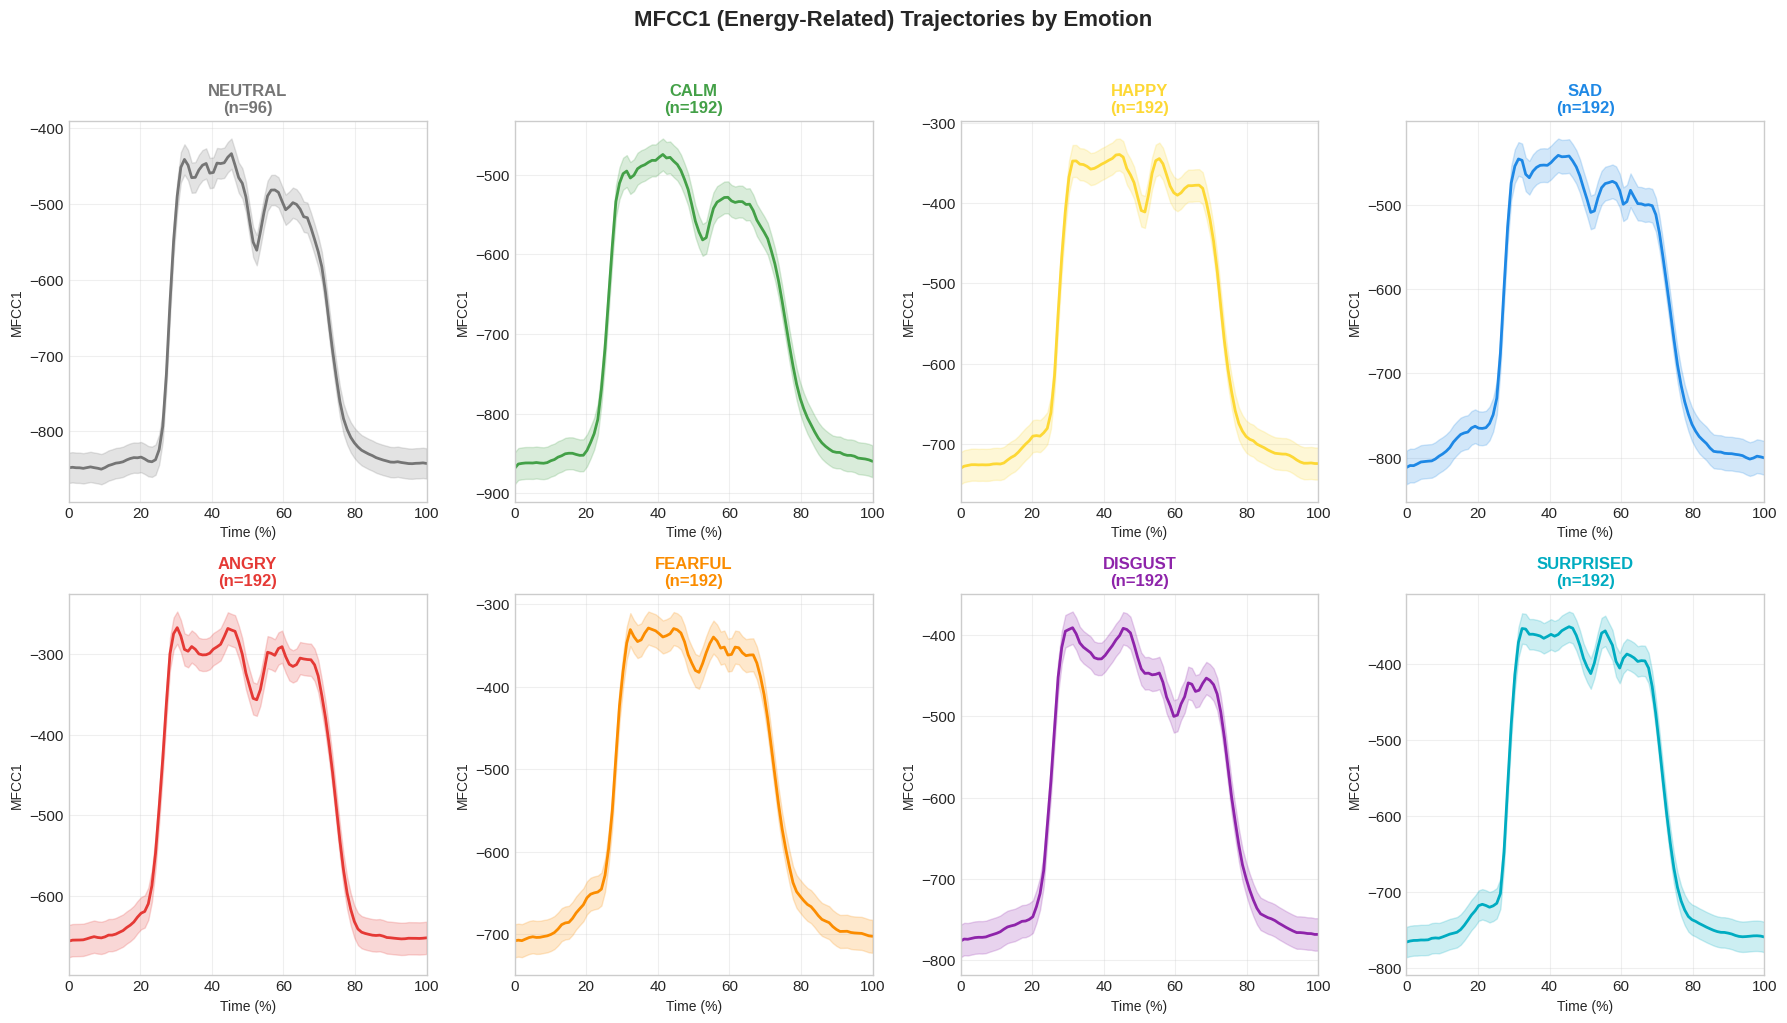

In [32]:
# =============================================================================
# MFCC1 TRAJECTORY COMPARISON (2x4 Grid)
# =============================================================================

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for ax, emotion in zip(axes, EMOTION_ORDER):
    color = EMOTION_COLORS[emotion]
    data = temporal_by_emotion[emotion]
    
    ax.plot(time_axis, data['mfcc1'], color=color, linewidth=2)
    ax.fill_between(time_axis, data['mfcc1'] - 20, data['mfcc1'] + 20, 
                    color=color, alpha=0.2)
    
    ax.set_title(f'{emotion.upper()}\n(n={data["n_samples"]})', 
                 fontsize=12, fontweight='bold', color=color)
    ax.set_xlabel('Time (%)', fontsize=10)
    ax.set_ylabel('MFCC1', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 100)

plt.suptitle('MFCC1 (Energy-Related) Trajectories by Emotion', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'mfcc1_trajectories.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Frequency Band Attribution

**Research Question**: Which frequency bands carry the most emotion-discriminative information?

**Approach**:
1. Divide the frequency spectrum into bands (sub-bass, bass, low-mid, mid, upper-mid, presence, brilliance)
2. Compute average energy in each band per sample
3. Analyze which bands differ most across emotions
4. Identify the "emotion fingerprint" in frequency space

**Frequency Bands** (based on audio engineering conventions):
| Band | Range (Hz) | Characteristics |
|------|------------|----------------|
| Sub-bass | 20-60 | Rumble, chest voice fundamentals |
| Bass | 60-250 | Fundamental frequencies, warmth |
| Low-mid | 250-500 | Body, fullness |
| Mid | 500-2000 | Vowel clarity, nasality |
| Upper-mid | 2000-4000 | Presence, consonant clarity |
| Presence | 4000-6000 | Definition, sibilance |
| Brilliance | 6000-11025 | Air, breathiness |

In [33]:
# =============================================================================
# DEFINE FREQUENCY BANDS
# =============================================================================

FREQUENCY_BANDS = {
    'sub_bass': (20, 60),
    'bass': (60, 250),
    'low_mid': (250, 500),
    'mid': (500, 2000),
    'upper_mid': (2000, 4000),
    'presence': (4000, 6000),
    'brilliance': (6000, 11025)  # Up to Nyquist at 22050 Hz
}

def extract_band_energies(filepath: str, sr: int = SAMPLE_RATE) -> dict:
    """Extract energy in each frequency band.
    
    Args:
        filepath (str): Path to audio file.
        sr (int): Sample rate.
    
    Returns:
        dict: Dictionary of band energies.
    """
    try:
        y, sr = librosa.load(filepath, sr=sr)
        
        # Compute STFT
        D = np.abs(librosa.stft(y))
        
        # Get frequency bins
        freqs = librosa.fft_frequencies(sr=sr)
        
        band_energies = {}
        for band_name, (low, high) in FREQUENCY_BANDS.items():
            # Find frequency bins in this band
            band_mask = (freqs >= low) & (freqs < high)
            
            # Compute mean energy in band
            if np.any(band_mask):
                band_energy = np.mean(D[band_mask, :])
            else:
                band_energy = 0
            
            band_energies[band_name] = band_energy
        
        return band_energies
        
    except Exception as e:
        return None

print(f"Defined {len(FREQUENCY_BANDS)} frequency bands.")

Defined 7 frequency bands.


In [34]:
# =============================================================================
# EXTRACT BAND ENERGIES FROM ALL FILES
# =============================================================================

print("Extracting frequency band energies...")

band_data = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting band energies"):
    energies = extract_band_energies(row['filepath'])
    
    if energies is not None:
        band_data.append({
            'emotion': row['emotion'],
            'gender': row['gender'],
            **energies
        })

df_bands = pd.DataFrame(band_data)
print(f"\nExtracted band energies from {len(df_bands)} files.")

Extracting frequency band energies...


Extracting band energies:   0%|          | 0/1440 [00:00<?, ?it/s]


Extracted band energies from 1440 files.


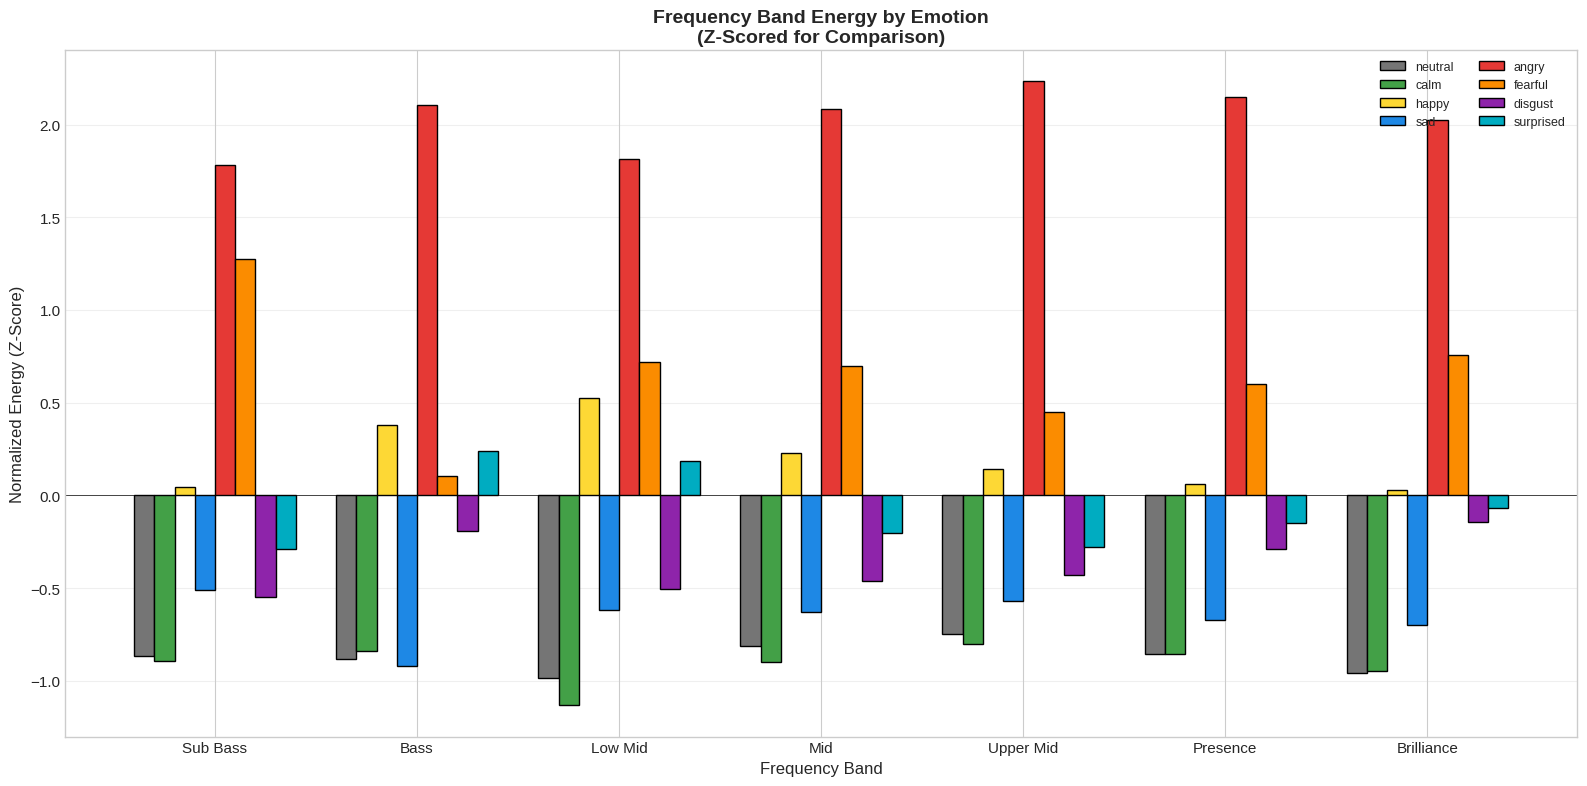

In [35]:
# =============================================================================
# BAND ENERGY BY EMOTION - GROUPED BAR CHART
# =============================================================================

band_names = list(FREQUENCY_BANDS.keys())
band_by_emotion = df_bands.groupby('emotion')[band_names].mean()
band_by_emotion = band_by_emotion.loc[EMOTION_ORDER]  # Reorder

# Normalize for comparison (z-score by band)
band_normalized = (band_by_emotion - band_by_emotion.mean()) / band_by_emotion.std()

fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(band_names))
width = 0.1
multiplier = 0

for emotion in EMOTION_ORDER:
    offset = width * multiplier
    rects = ax.bar(x + offset, band_normalized.loc[emotion], width, 
                   label=emotion, color=EMOTION_COLORS[emotion], edgecolor='black')
    multiplier += 1

ax.set_xlabel('Frequency Band', fontsize=12)
ax.set_ylabel('Normalized Energy (Z-Score)', fontsize=12)
ax.set_title('Frequency Band Energy by Emotion\n(Z-Scored for Comparison)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 3.5)
ax.set_xticklabels([b.replace('_', ' ').title() for b in band_names], fontsize=11)
ax.legend(loc='upper right', fontsize=9, ncol=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'band_energy_by_emotion.png', dpi=150, bbox_inches='tight')
plt.show()

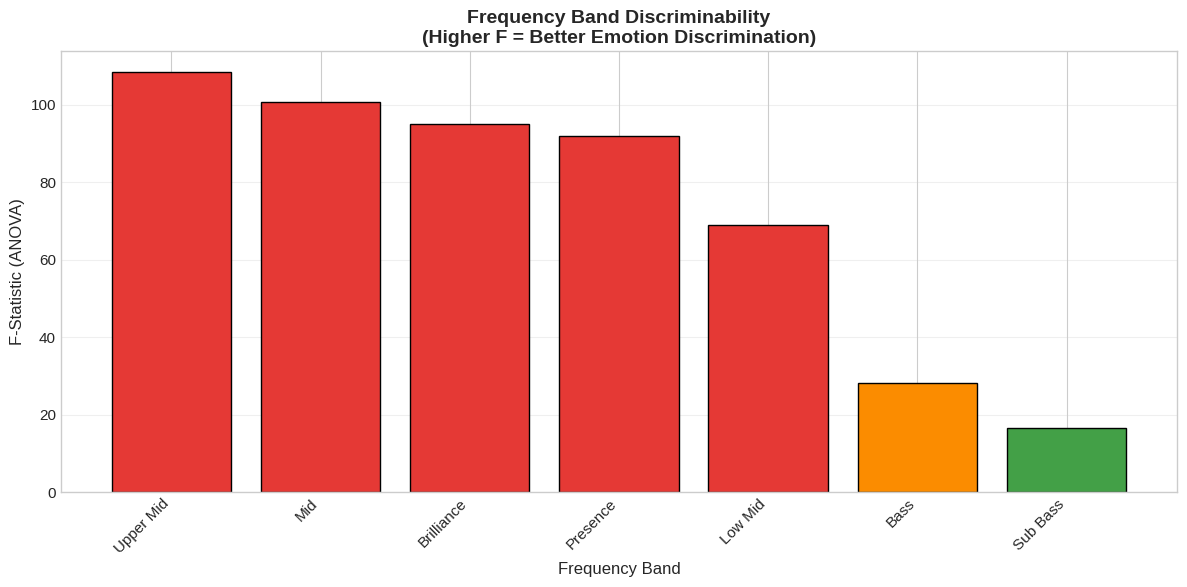


=== BAND DISCRIMINABILITY RANKING ===
1. Upper Mid: F = 108.5, p < 0.00e+00
2. Mid: F = 100.8, p < 0.00e+00
3. Brilliance: F = 95.0, p < 0.00e+00
4. Presence: F = 91.9, p < 0.00e+00
5. Low Mid: F = 69.0, p < 0.00e+00
6. Bass: F = 28.1, p < 2.21e-36
7. Sub Bass: F = 16.6, p < 3.93e-21


In [36]:
# =============================================================================
# BAND DISCRIMINABILITY - F-STATISTIC (ANOVA)
# =============================================================================

f_stats = {}

for band in band_names:
    groups = [df_bands[df_bands['emotion'] == e][band].values for e in EMOTION_ORDER]
    f_stat, p_val = stats.f_oneway(*groups)
    f_stats[band] = {'f_statistic': f_stat, 'p_value': p_val}

f_stat_df = pd.DataFrame(f_stats).T.sort_values('f_statistic', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#E53935' if f > 50 else '#FB8C00' if f > 20 else '#43A047' 
          for f in f_stat_df['f_statistic']]

bars = ax.bar(range(len(f_stat_df)), f_stat_df['f_statistic'], 
              color=colors, edgecolor='black')

ax.set_xticks(range(len(f_stat_df)))
ax.set_xticklabels([b.replace('_', ' ').title() for b in f_stat_df.index], 
                   rotation=45, ha='right', fontsize=11)
ax.set_xlabel('Frequency Band', fontsize=12)
ax.set_ylabel('F-Statistic (ANOVA)', fontsize=12)
ax.set_title('Frequency Band Discriminability\n(Higher F = Better Emotion Discrimination)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'band_discriminability.png', dpi=150, bbox_inches='tight')
plt.show()

# Save F-statistics
f_stat_df.to_csv(OUTPUT_PATH / 'frequency_band_fstats.csv')

print("\n=== BAND DISCRIMINABILITY RANKING ===")
for i, (band, row) in enumerate(f_stat_df.iterrows(), 1):
    print(f"{i}. {band.replace('_', ' ').title()}: F = {row['f_statistic']:.1f}, p < {row['p_value']:.2e}")

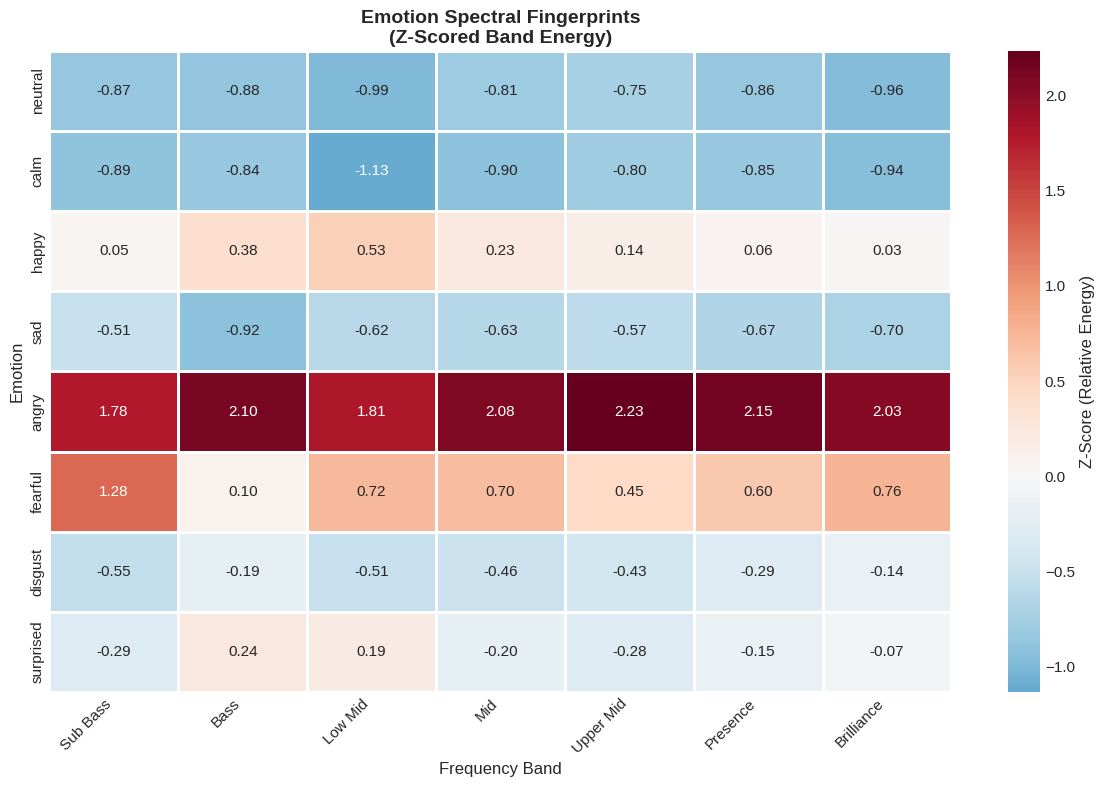

In [37]:
# =============================================================================
# EMOTION SPECTRAL FINGERPRINTS HEATMAP
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(band_normalized, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            linewidths=1, cbar_kws={'label': 'Z-Score (Relative Energy)'}, ax=ax)

ax.set_title('Emotion Spectral Fingerprints\n(Z-Scored Band Energy)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Frequency Band', fontsize=12)
ax.set_ylabel('Emotion', fontsize=12)

# Rotate x labels
ax.set_xticklabels([b.replace('_', ' ').title() for b in band_names], 
                   rotation=45, ha='right', fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'emotion_spectral_fingerprints.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Synthesis: Key Findings and Modeling Implications

### 9.1 Key Findings Summary

| Analysis | Key Finding | Modeling Implication |
|----------|-------------|---------------------|
| **Speaker Analysis** | Gender is the dominant clustering factor; individual actor signatures exist | Use GroupKFold with actor_id; consider speaker normalization |
| **Emotion Space** | Emotions show partial overlap; calm-neutral and fear-surprise are closest | Expect confusion between similar emotion pairs |
| **Cross-Emotion Distances** | Low separability for calm-neutral, fear-surprise, happy-surprised | May need hierarchical classification (arousal first) |
| **Intensity Effects** | Energy features (RMS, spectral centroid) most intensity-sensitive | Consider intensity as additional target or feature |
| **Temporal Patterns** | Distinct pitch/energy contours per emotion | Sequence models (LSTM) may capture dynamics |
| **Frequency Bands** | Upper-mid (2-4 kHz) most discriminative | Band-specific features may improve accuracy |

In [38]:
# =============================================================================
# GENERATE SUMMARY STATISTICS TABLE
# =============================================================================

summary_stats = {
    'Metric': [
        'Total Samples',
        'Total Actors',
        'Emotions',
        'Features Extracted',
        'PCA Variance (2D)',
        'Most Similar Emotion Pair',
        'Least Similar Emotion Pair',
        'Most Intensity-Sensitive Feature',
        'Most Discriminative Band'
    ],
    'Value': [
        len(df),
        df['actor'].nunique(),
        df['emotion'].nunique(),
        len(FEATURE_NAMES),
        f"{sum(pca_emotion.explained_variance_ratio_)*100:.1f}%",
        fisher_df.iloc[0]['pair'],
        fisher_df.iloc[-1]['pair'],
        feature_intensity_sensitivity.index[0],
        f_stat_df.index[0].replace('_', ' ').title()
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("=== ANALYSIS SUMMARY ===")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(OUTPUT_PATH / 'analysis_summary.csv', index=False)

=== ANALYSIS SUMMARY ===
                          Metric           Value
                   Total Samples            1440
                    Total Actors              24
                        Emotions               8
              Features Extracted              86
               PCA Variance (2D)           37.2%
       Most Similar Emotion Pair neutral vs calm
      Least Similar Emotion Pair   calm vs angry
Most Intensity-Sensitive Feature     mfcc_1_mean
        Most Discriminative Band       Upper Mid


### 9.2 Recommendations for Modeling Phase

Based on this analysis, I recommend:

**1. Data Splitting Strategy**
- Use **GroupKFold** with `actor_id` as group to prevent speaker identity leakage
- Stratify by emotion within each fold

**2. Feature Engineering**
- Include band-specific energy features (especially upper-mid and presence bands)
- Consider temporal features (pitch/energy contour statistics) for non-deep models
- Add intensity as a feature if not using as separate target

**3. Model Selection Strategy**
- **Baseline**: SVM/XGBoost on Pratheek's 33 compact features
- **Deep Learning**: CNN on mel-spectrograms (Nithya's approach)
- **Sequence Models**: Consider LSTM on frame-level features if temporal patterns prove important
- **Ensemble**: Combine predictions from different feature representations

**4. Post-hoc Analysis**
- Compare predicted vs. actual confusion matrices
- Analyze per-speaker performance to identify problematic actors
- Test with gender-stratified models if gender-emotion interactions are significant

**5. Potential Improvements**
- Intensity-aware models (predict intensity alongside emotion, or use as conditioning)
- Data augmentation: pitch shifting, noise injection (per README recommendations)
- Transfer learning from pre-trained audio models (wav2vec2, HuBERT)

In [39]:
# =============================================================================
# SAVE ALL ANALYSIS ARTIFACTS
# =============================================================================

print("=== SAVED ARTIFACTS ===")
print(f"Output directory: {OUTPUT_PATH}")
print("\nFiles saved:")

for f in sorted(OUTPUT_PATH.glob('*')):
    size_kb = f.stat().st_size / 1024
    print(f"  - {f.name} ({size_kb:.1f} KB)")

print(f"\nTotal artifacts: {len(list(OUTPUT_PATH.glob('*')))} files")

=== SAVED ARTIFACTS ===
Output directory: /home/bjorn/repos/berkeley/DS207/EDFS/data/processed/bjorn_analysis

Files saved:
  - actor_dendrogram.png (75.6 KB)
  - actor_pca_scatter.png (99.4 KB)
  - actor_similarity_heatmap.png (99.2 KB)
  - actor_similarity_matrix.csv (11.3 KB)
  - analysis_summary.csv (0.3 KB)
  - band_discriminability.png (70.1 KB)
  - band_energy_by_emotion.png (77.8 KB)
  - emotion_dendrogram.png (69.5 KB)
  - emotion_distance_heatmap.png (125.5 KB)
  - emotion_distances.csv (1.1 KB)
  - emotion_pca_ellipses.png (690.7 KB)
  - emotion_separability.png (186.9 KB)
  - emotion_spectral_fingerprints.png (156.4 KB)
  - emotion_tsne.png (428.6 KB)
  - emotion_tsne_by_gender.png (508.8 KB)
  - emotion_umap.png (400.3 KB)
  - energy_envelopes.png (351.0 KB)
  - frequency_band_fstats.csv (0.2 KB)
  - intensity_effect_heatmap.png (385.8 KB)
  - intensity_effect_sizes.csv (22.9 KB)
  - intensity_volcano_plot.png (134.5 KB)
  - mfcc1_trajectories.png (437.9 KB)
  - pitch_cont

---

## End of Analysis

**Notebook completed**: All 6 unique analysis perspectives covered.

**Next Steps**: Proceed to Milestone 2 modeling with insights from this EDA.

**Citation**: Please cite RAVDESS when publishing results:
```
Livingstone, S.R., & Russo, F.A. (2018). The Ryerson Audio-Visual Database of 
Emotional Speech and Song (RAVDESS). PLOS ONE, 13(5), e0196391.
https://doi.org/10.1371/journal.pone.0196391
```